In [1]:
%matplotlib inline
%cd /users/jburba/data/jburba/hera-validation/test-series/3/

import numpy as np
import os, sys, glob
import hera_pspec
import pyuvdata
import h5py
import copy

from pyuvdata import UVData, utils as uvutils
from matplotlib.pyplot import *

/gpfs/data/jpober/jburba/hera-validation/test-series/3


In [3]:
rcParams.update({'font.size': 14, 'figure.figsize':(12, 8)})

In [4]:
def waterfall_column(waterfalls, flags, titles, clims=None, clabels=None, cmaps=None, ylims=None, 
                     ylabel='', xlabel='', extents=None, hspace=.1, figsize=(12,6), dpi=100, fignum=None, logs=None,
                     fig_title=None):
    '''Useful plotting function for the IDR 2.2 memo.'''
    if clims is None:
        clims = [None for i in range(len(waterfalls))]
    if clabels is None:
        clabels = [None for i in range(len(waterfalls))]
    if cmaps is None:
        cmaps = [None for i in range(len(waterfalls))]
    if ylims is None:
        ylims = [None for i in range(len(waterfalls))]
    if not any(isinstance(ex, list) for ex in extents):
        extents = [extents for i in range(len(waterfalls))]
    if fignum is None:
        fig, axes = subplots(len(waterfalls), 1, sharex=True, squeeze=True, figsize=figsize, dpi=dpi)
    else:
        fig, axes = subplots(len(waterfalls), 1, sharex=True, squeeze=True, figsize=figsize, dpi=dpi, num=fignum)
    subplots_adjust(hspace=hspace)
    for ax, wf, f, t, clim, clabel, cmap, ylim, ex, log in zip(axes, waterfalls, flags, titles,
                                                          clims, clabels, cmaps, ylims, extents, logs):
        with np.errstate(divide='ignore', invalid='ignore'):
            if not log:
                im = ax.imshow(wf / ~f, aspect='auto', extent=ex, cmap=cmap, interpolation='none')
                colorbar(im, ax=ax, label=clabel, aspect=8, pad=.025)
            else:
                im = ax.imshow(np.log10(wf / ~f), aspect='auto', extent=ex, cmap=cmap, interpolation='none')
                colorbar(im, ax=ax, label='Log ' + clabel, aspect=8, pad=.025)
        if ax == axes[-1]:
            ax.set_xlabel(xlabel)    
        im.set_clim(clim)
        ax.set_ylabel(ylabel)
        ax.set_ylim(ylim)
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.02, 0.9, t, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    if not fig_title is None:
        axes[0].set_title(fig_title)
    fig.tight_layout()

def make_fig(figsize=(9, 7), fignum=1):
    fig = figure(fignum)
    units = 'in'
    fig.canvas.layout.width = str(figsize[0]) + units
    fig.canvas.layout.height = str(figsize[1]) + units
    return fig

For whatever reason, the vis_units for all 2458101 datafiles which have the OCRSD extension have uncalibrated units.

In [5]:
data_path = '/users/jburba/data/jburba/hera-validation/test-series/3/'
# raw_datafile = 'hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.uvh5'
# x_datafile = 'hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.X.uvh5'
# p_datafile = 'hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.XP.uvh5'
# x_datafile = 'hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.X.uvh5'
# p_datafile = 'pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.XP.uvh5'
raw_datafile = 'sum_data.first_half.uvh5'
x_datafile = 'hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.X.uvh5'
p_datafile = 'sum_data.first_half.XP.uvh5'

uvd = UVData()
uvd.read(os.path.join(data_path, raw_datafile), read_data=False)

Telescope RIMEz calculation is not in known_telescopes.


In [6]:
!ls -lt --block-size=GB $data_path/*first_half*

-rw-r--r--. 1 jburba jpober  1GB Dec  1 17:56 /users/jburba/data/jburba/hera-validation/test-series/3//sum_data.first_half.XP.spw_400-600.psc
-rw-r--r--. 1 jburba jpober  1GB Dec  1 17:56 /users/jburba/data/jburba/hera-validation/test-series/3//sum_data.first_half.spw_400-600.psc
-rw-r--r--. 1 jburba jpober  1GB Dec  1 17:54 /users/jburba/data/jburba/hera-validation/test-series/3//sum_data.first_half.XP.mult_spws_v4.psc
-rw-r--r--. 1 jburba jpober  1GB Dec  1 17:53 /users/jburba/data/jburba/hera-validation/test-series/3//sum_data.first_half.mult_spws_v4.psc
-rw-r--r--. 1 jburba jpober  1GB Nov 26 18:07 /users/jburba/data/jburba/hera-validation/test-series/3//sum_data.first_half.XP.uvh5
-rw-r--r--. 1 jburba jpober  1GB Nov 26 18:07 /users/jburba/data/jburba/hera-validation/test-series/3//sum_data.first_half.uvh5
-rw-r--r--. 1 jburba jpober 18GB Nov  3 23:07 /users/jburba/data/jburba/hera-validation/test-series/3//hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_e

In [7]:
bls = [(13, 12), (29, 27)]
flag_nchan_low, flag_nchan_high = 150, 150
chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
# times = np.unique(uvd.time_array)[:(uvd.Ntimes // 2)]
times = None

uvd_raw = UVData()
uvd_raw.read(os.path.join(data_path, raw_datafile), bls=bls, times=times)

uvd_x = UVData()
uvd_x.read(os.path.join(data_path, x_datafile), bls=bls) # uncalibrated units in uvd.vis_units

uvd_xp = UVData()
uvd_xp.read(os.path.join(data_path, p_datafile), bls=bls) # uncalibrated units in uvd_p.vis_units

zero_int_flags_1213 = np.where(np.sum(np.logical_not(uvd_xp.get_flags((12, 13, 'xx'))), axis=1) == 0)[0]
zero_int_flags_2927 = np.where(np.sum(np.logical_not(uvd_xp.get_flags((29, 27, 'xx'))), axis=1) == 0)[0]

Telescope RIMEz calculation is not in known_telescopes.


In [140]:
fig = make_fig(figsize=(14, 12), fignum=1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Flagging fraction = 0.36632906614816196
Flagging fraction = 0.18397097045996602


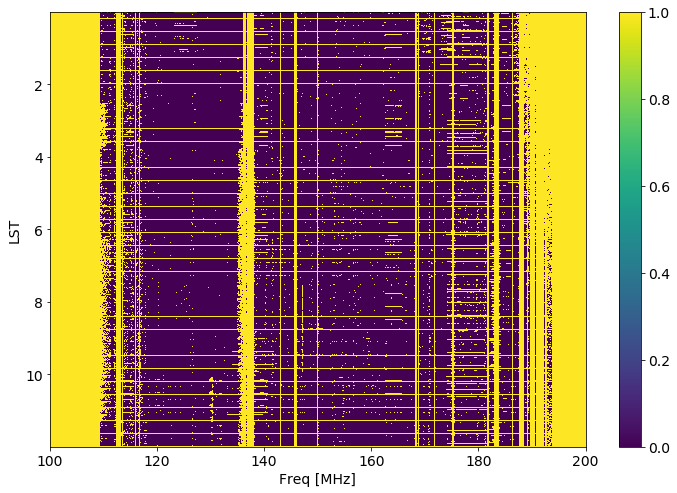

In [19]:
fig = figure(45)
extent = [uvd.freq_array[0, 0]/1e6,
          uvd.freq_array[0, -1]/1e6,
          np.rad2deg(uvd.lst_array[-1]) / 15.0, np.rad2deg(uvd.lst_array[0]) / 15.0]
imshow(uvd_x.get_flags(bl).astype('int'), extent=extent, aspect='auto')
colorbar()
xlabel('Freq [MHz]')
ylabel('LST')
print('Flagging fraction = {}'.format(np.sum(uvd_x.get_flags(bl)) / uvd_x.get_flags(bl).size))
print('Flagging fraction = {}'.format(np.sum(uvd_x.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]) / uvd_x.get_flags(bl)[:, freq_inds[0]:freq_inds[1]].size))

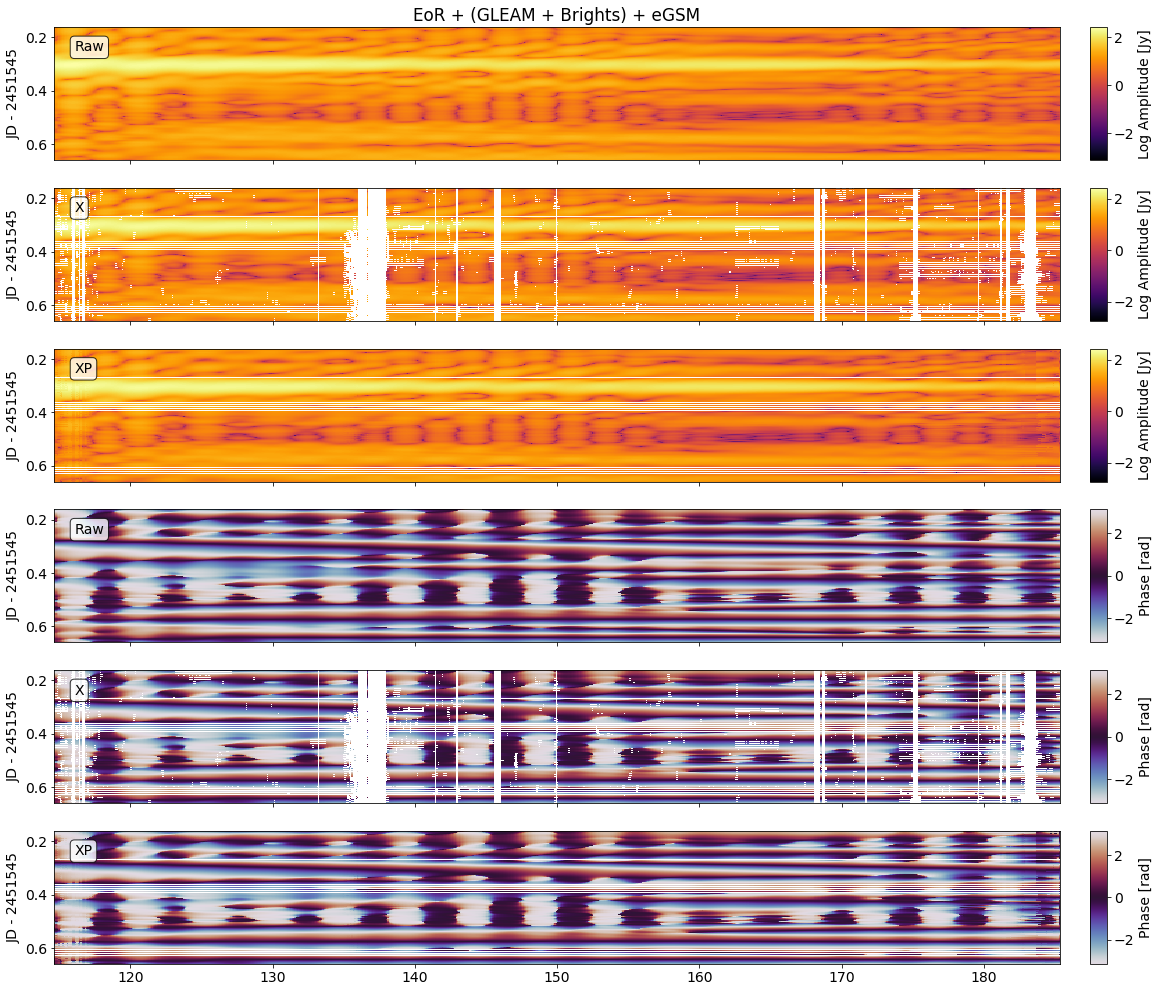

In [8]:
fig = figure(1, figsize=(18, 14))
# fig = figure(1)
clf()
bl = ((12, 13, 'xx'))
# freq_inds = [50, -50]
freq_inds = [flag_nchan_low, -flag_nchan_high]
# freq_inds = [400, 600]
plot_freqs = uvd_x.freq_array[0, freq_inds[0]:freq_inds[1]]
extent = [plot_freqs[0] / 1.0e6, plot_freqs[-1] / 1.0e6,
          uvd_raw.time_array[-1] - 2451545, uvd_raw.time_array[0] - 2451545]

waterfall_column([np.abs(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.abs(uvd_x.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.abs(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.angle(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.angle(uvd_x.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.angle(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]])],
                 [uvd_raw.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_x.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_raw.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_x.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]],
                 ['Raw', 'X', 'XP', 'Raw', 'X', 'XP'],
                 extents = [extent] * 6,
                 clabels = ['Amplitude [Jy]'] * 3 + ['Phase [rad]'] * 3,
                 cmaps = ['inferno'] * 3 + ['twilight'] * 3,
                 ylabel = 'JD - 2451545',
                 logs = [True, True, True, False, False, False],
                 fignum=1,
                 fig_title='EoR + (GLEAM + Brights) + eGSM');

In [142]:
fig = make_fig(figsize=(13, 6), fignum=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

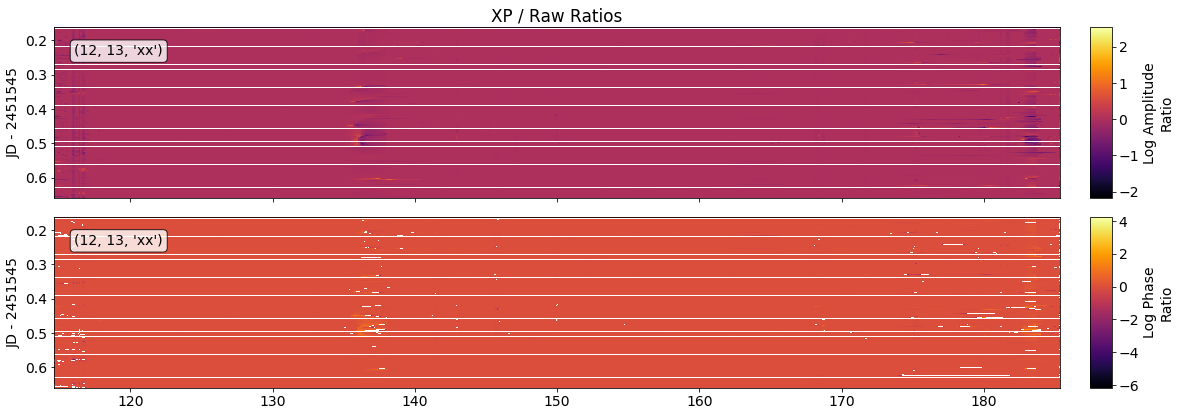

In [319]:
fig = figure(2, figsize=(18, 6))
# fig = figure(2)
clf()
freq_inds = [flag_nchan_low, -flag_nchan_high]
# freq_inds = [400, 600]
plot_freqs = uvd_x.freq_array[0, freq_inds[0]:freq_inds[1]]
extent = [plot_freqs[0] / 1.0e6, plot_freqs[-1] / 1.0e6,
          uvd_raw.time_array[-1] - 2451545, uvd_raw.time_array[0] - 2451545]

waterfall_column([((np.abs(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]]))
                    /
                    np.abs(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]])),
                  ((np.angle(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]]))
                    /
                    np.angle(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]]))],
                 [uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]],
                 [bl] * 2,
                 extents = [extent] * 2,
                 clabels = ['Amplitude\nRatio', 'Phase\nRatio'],
                 cmaps = ['inferno'] * 2,
                 ylabel = 'JD - 2451545',
                 logs = [True, True],
                 fignum=2,
                 fig_title='XP / Raw Ratios');

In [144]:
fig = make_fig(figsize=(13, 12), fignum=3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

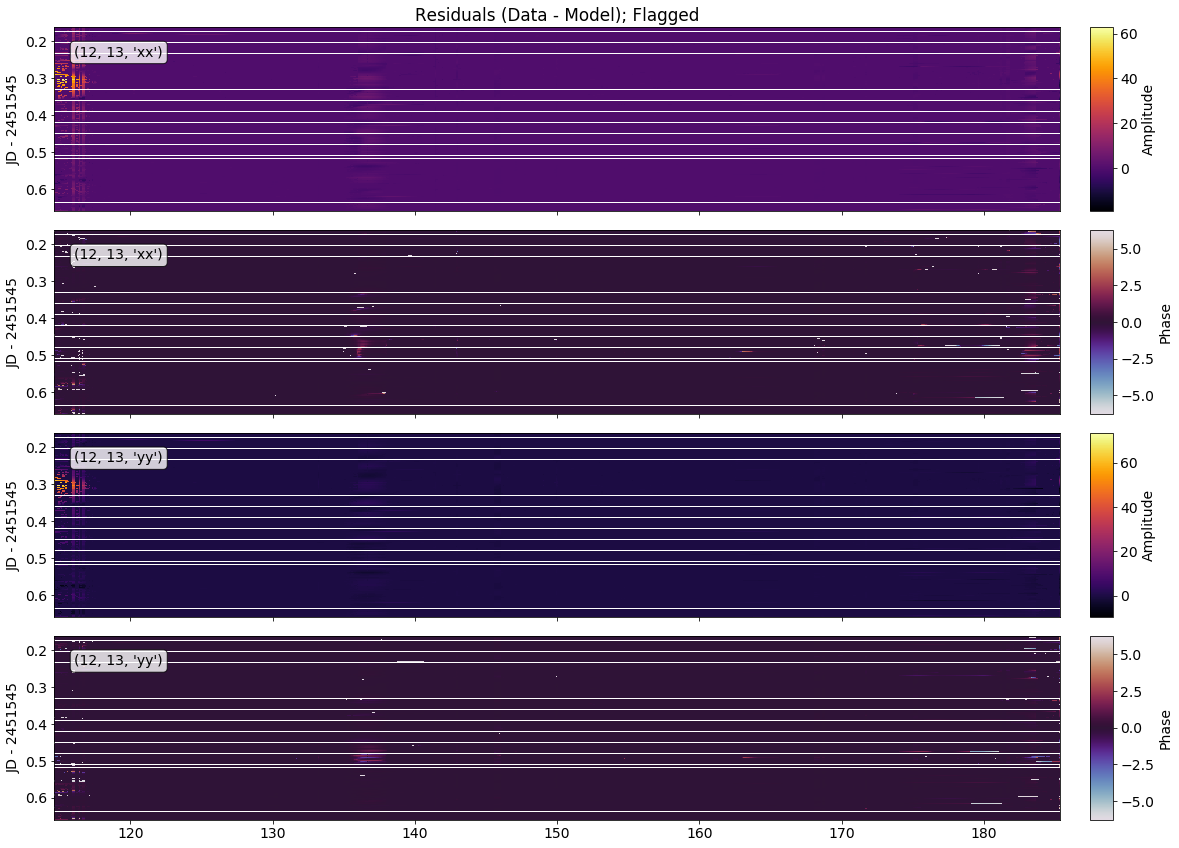

In [24]:
fig = figure(3, figsize=(18, 12))
# fig = figure(3)
clf()
blxx = ((12, 13, 'xx'))
blyy = ((12, 13, 'yy'))
freq_inds = [flag_nchan_low, -flag_nchan_high]
# freq_inds = [400, 600]
plot_freqs = uvd_x.freq_array[0, freq_inds[0]:freq_inds[1]]
extent = [plot_freqs[0] / 1.0e6, plot_freqs[-1] / 1.0e6,
          uvd_xp.time_array[-1] - 2451545, uvd_xp.time_array[0] - 2451545]

flags = uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]
# flags = np.zeros_like(uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]])
fig_title = 'Residuals (Data - Model)'
if np.sum(flags) == 0:
    fig_title += '; Unflagged'
else:
    fig_title += '; Flagged'

waterfall_column([(np.abs(uvd_raw.get_data(blxx)[:, freq_inds[0]:freq_inds[1]]) - (np.abs(uvd_xp.get_data(blxx)[:, freq_inds[0]:freq_inds[1]]))),
                  (np.angle(uvd_raw.get_data(blxx)[:, freq_inds[0]:freq_inds[1]]) - (np.angle(uvd_xp.get_data(blxx)[:, freq_inds[0]:freq_inds[1]]))),
                  (np.abs(uvd_raw.get_data(blyy)[:, freq_inds[0]:freq_inds[1]]) - (np.abs(uvd_xp.get_data(blyy)[:, freq_inds[0]:freq_inds[1]]))),
                  (np.angle(uvd_raw.get_data(blyy)[:, freq_inds[0]:freq_inds[1]]) - (np.angle(uvd_xp.get_data(blyy)[:, freq_inds[0]:freq_inds[1]])))],
                 [flags] * 4,
                 [blxx, blxx, blyy, blyy],
                 extents = [extent] * 4,
                 clabels = ['Amplitude', 'Phase'] * 2,
                 cmaps = ['inferno', 'twilight'] * 2,
                 ylabel = 'JD - 2451545',
                 logs = [False, False, False, False],
                 fignum=3,
                 fig_title=fig_title);

In [146]:
fig = make_fig(figsize=(14, 8), fignum=4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

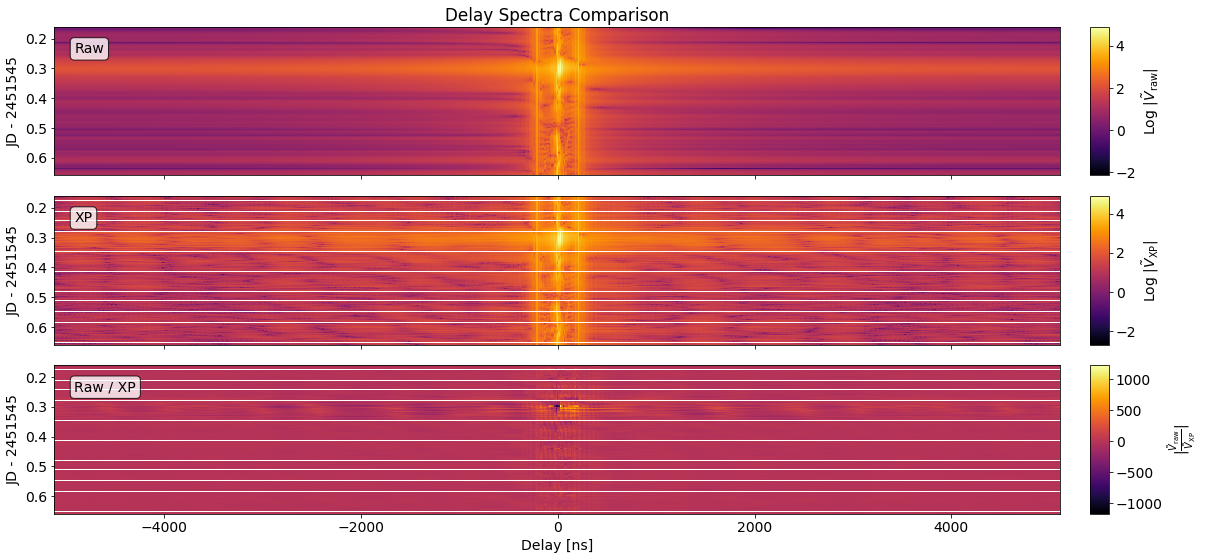

In [26]:
fig = figure(4, figsize=(18, 8))
# fig = figure(4)
clf()
bl = ((12, 13, 'xx'))
freq_inds = [flag_nchan_low, -flag_nchan_high]
# freq_inds = [600, 800]
plot_freqs = uvd_x.freq_array[0, freq_inds[0]:freq_inds[1]]

axes_tuple = (1,)
fft_raw = np.fft.ifftshift(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]], axes=axes_tuple)
fft_raw = np.fft.fftn(fft_raw, axes=axes_tuple)
fft_raw = np.fft.fftshift(fft_raw, axes=axes_tuple)
fft_xp = np.fft.ifftshift(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]], axes=axes_tuple)
fft_xp = np.fft.fftn(fft_xp, axes=axes_tuple)
fft_xp = np.fft.ifftshift(fft_xp, axes=axes_tuple)
delays = np.fft.fftshift(np.fft.fftfreq(plot_freqs.size, d=np.diff(plot_freqs)[0]))
extent = [delays[0] / 1e-9, delays[-1] / 1e-9,
          uvd_raw.time_array[-1] - 2451545, uvd_raw.time_array[0] - 2451545]

waterfall_column([np.abs(fft_raw), np.abs(fft_xp), np.abs(fft_raw) - np.abs(fft_xp)],
                 [np.zeros_like(uvd_raw.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]),
                  uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]],
                 ['Raw', 'XP', 'Raw / XP'],
                 extents = [extent] * 3,
                 clabels = [r'$|\tilde{V}_{\rm{raw}}|$', r'$|\tilde{V}_{\rm{XP}}|$', r'$\left| \frac{\tilde{V}_{\rm{raw}}}{\tilde{V}_{\rm{XP}}} \right|$'],
                 cmaps = ['inferno'] * 3,
                 ylabel = 'JD - 2451545',
                 xlabel = 'Delay [ns]',
                 logs = [True, True, False],
                 fignum=4,
                 fig_title='Delay Spectra Comparison')

In [27]:
ratio_ds = fft_raw / (fft_xp / (~uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]))
ratio_abs_ds = np.abs(fft_raw) / (np.abs(fft_xp) / (~uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]))
ratio_phase_ds = np.angle(fft_raw) / (np.angle(fft_xp) / (~uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]))
abs_max_inds = np.where(ratio_abs_ds == np.nanmax(ratio_abs_ds))
phase_max_inds = np.where(ratio_phase_ds == np.nanmax(ratio_phase_ds))
max_inds = np.where(ratio_ds == np.nanmax(ratio_ds))
print(np.nanmax(ratio_abs_ds))
print(np.where(ratio_abs_ds == np.nanmax(ratio_abs_ds)))
print(ratio_abs_ds[np.where(ratio_abs_ds == np.nanmax(ratio_abs_ds))])

invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


1726.7961754016026
(array([2972]), array([150]))
[1726.7961754]


divide by zero encountered in true_divide
invalid value encountered in true_divide


In [160]:
fig = make_fig(figsize=(7, 5), fignum=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

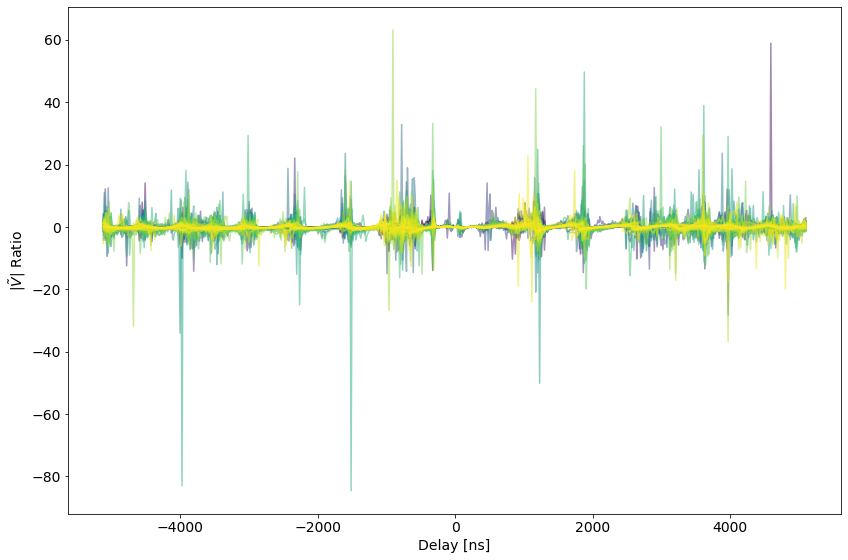

In [30]:
fig = figure(5, figsize=(12, 8))
# figure(5).clf()
time_inds = np.arange(600, 800)
for i_t in time_inds:
    plot(delays * 1e9, ratio_ds[i_t].imag, c=cm.viridis((i_t - time_inds[0])/(time_inds[-1] - time_inds[0])), alpha=0.5)
# plot(delays * 1e9, ratio_abs_ds[abs_max_inds[0]][0].real**2, label='real')
# plot(delays * 1e9, ratio_abs_ds[abs_max_inds[0]][0].imag, label='imag')
xlabel('Delay [ns]')
ylabel(r'$|\tilde{V}|$ Ratio')
# legend(loc='best')
tight_layout()

<br>  

___

# HERA Pspec Analysis

In [10]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path, flag_nchan_low=50, flag_nchan_high=50, blpairs=None):
    # choose only data that hasn't been flagged, assuming 1024 frequency channels
    chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
    
    if not blpairs is None:
        bls = [blp[0] for blp in blpairs]
    else:
        bls = None
    
    uvd = UVData()
    uvd.read_uvh5(vis_data_path, bls=bls, freq_chans=chans, keep_all_metadata=False)
    
    print('Vis units = {}'.format(uvd.vis_units))
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_residual_data(vis_data_paths, flag_nchan_low=50, flag_nchan_high=50, blpairs=None):
    # choose only data that hasn't been flagged, assuming 1024 frequency channels
    chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
    
    if not blpairs is None:
        bls = [blp[0] for blp in blpairs]
    else:
        bls = None
    
    print('Reading data from {}'.format(vis_data_paths[0]))
    uvd1 = UVData()
    uvd1.read_uvh5(vis_data_paths[0], bls=bls, freq_chans=chans, keep_all_metadata=False)
    print(uvd1.data_array.shape)
    
    print('Reading data from {}'.format(vis_data_paths[1]))
    uvd2 = UVData()
    uvd2.read_uvh5(vis_data_paths[1], bls=bls, freq_chans=chans, keep_all_metadata=False)
    print(uvd2.data_array.shape)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]

    VI_data = ((uvd1.data_array[..., xx_ind] - uvd2.data_array[..., xx_ind])
               +
               (uvd1.data_array[..., yy_ind] - uvd2.data_array[..., yy_ind]))
    
    uvd1.select(polarizations=(-5))
    uvd1.polarization_array[0] = 1
    uvd1.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd1

def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hera_pspec.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                         Om_b=Om_b,
                                                         Om_c=Om_c,
                                                         H0=H0,)
    return hps_cosmo

# define the cosmology
cosmo = astropyPlanck15_for_hera_pspec()

# choose only the unflagged frequencies
flag_nchan_low, flag_nchan_high = (50, 50)
freq_slice = slice(flag_nchan_low, -flag_nchan_high)

# load beam-dependent normalization data
omegas_data_path = '/users/jburba/data/jburba/hera-validation/test-series/3/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()][freq_slice]
    Omegapp = h5f['Omegapp'][()][freq_slice]

beam = hera_pspec.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, np.unique(uvd.freq_array[0, freq_slice]), cosmo=cosmo)

def calc_pspec(vis_file, outfile, spw_ranges=None, blpairs=None):
    uvdI = get_VI_data(vis_file, blpairs=blpairs)
    _ = hera_pspec.pspecdata.pspec_run([uvdI, uvdI], outfile, file_type="uvh5",
                                       taper="blackman-harris", beam=beam, cosmo=cosmo,
                                       spw_ranges=spw_ranges, blpairs=blpairs, pol_pairs=[('pI','pI')],
                                       Jy2mK=True, exclude_cross_bls=True, 
                                       overwrite=True, verbose=True)
    del(uvdI)
    
def calc_pspec_residuals(vis_files, outfile, spw_ranges=None, blpairs=None):
    uvdI = get_VI_residual_data(vis_files, blpairs=blpairs)
    _ = hera_pspec.pspecdata.pspec_run([uvdI, uvdI], outfile, file_type="uvh5",
                                       taper="blackman-harris", beam=beam, cosmo=cosmo,
                                       spw_ranges=spw_ranges, blpairs=blpairs, pol_pairs=[('pI','pI')],
                                       Jy2mK=True, exclude_cross_bls=True, 
                                       overwrite=True, verbose=True)
    del(uvdI)

def get_pspec(pspec_file, key, fold=True, avg=True, return_kparas=True, return_kperps=False):
    psc = hera_pspec.container.PSpecContainer(pspec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    if fold:
        uvp.fold_spectra()
    pspec = uvp.get_data(key)
    if avg:
        pspec = pspec.mean(axis=0)
    output = [pspec,]
    if return_kparas:
        output.append(uvp.get_kparas(0))
    if return_kperps:
        output.append(uvp.get_kperps(0))
    return output

### Calculate power spectra

In [32]:
!ls $data_path/

data_minus_model_residuals.spw_400-600.psc
delay_in-painting_checkout.ipynb
flags_and_bl_array_dic.npy
HERA_dipole_Omegas
hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.X.uvh5
hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.mult_spws.psc
hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.second_half.X.mult_spws.psc
hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.second_half.X.uvh5
hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.spw_400-600.psc
hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.uvh5
hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.XP.mult_spws.psc
hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.XP.spw_400-600.psc
hera_hex37_100-200MHz_HERA_dipole_beam

# Sum Dataset and Power Spectra

In [21]:
spws = [(400, 600)]
blps = [((13,12),(13,12)),((29,27),(29,27))]

data_path = '/users/jburba/data/jburba/hera-validation/test-series/3/'
vis_files = [os.path.join(data_path, raw_datafile),
             os.path.join(data_path, p_datafile)]
print('Visibility Files:\n' + '-'*17)
for fn in vis_files:
    print(fn)
    
if len(spws) == 1:
    pspec_files = [fn.replace('.uvh5', '.spw_{}-{}.psc'.format(spws[0][0], spws[0][1])) for fn in vis_files]
else:
    pspec_files = [fn.replace('.uvh5', '.mult_spws_v4.psc') for fn in vis_files]
print('\nPspec Files:\n' + '-'*12)
for fn in pspec_files:
    print(fn)

Visibility Files:
-----------------
/users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.uvh5
/users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.XP.uvh5

Pspec Files:
------------
/users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.spw_400-600.psc
/users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.XP.spw_400-600.psc


In [237]:
for vis_file, pspec_file in zip(vis_files, pspec_files):
    print("Extracting spectrum from {}".format(os.path.basename(vis_file)))
    calc_pspec(vis_file, pspec_file, spws, blps)

Extracting spectrum from sum_data.first_half.uvh5
Vis units = Jy
Cannot convert dset 1 Jy -> mK because vis_units = mK
Opening /users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.spw_400-600.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((13, 12), (13, 12))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((29, 27), (29, 27))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...
Storing dset0_x_dset1
Extracting spectrum from sum_data.first_half.XP.uvh5
Vis units = Jy
Cannot convert dset 1 Jy -> mK because vis_units = mK
Opening /users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.XP.spw_400-600.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((13, 12), (13, 12))
pol

In [22]:
avg = False
spectra_xp_14m, kparas_xp_14m = [], []
for i_spw in range(len(spws)):
    key = (i_spw, blps[0], 'pI')
    spectra = []
    kparas = []
    for pspec_file in pspec_files:
        output = get_pspec(pspec_file, key, avg=avg)
        spectra.append(output[0])
        kparas.append(output[1])
    spectra_xp_14m.append(spectra)
    kparas_xp_14m.append(kparas)

spectra_xp_29m, kparas_xp_29m = [], []
for i_spw in range(len(spws)):
    key = (i_spw, blps[1], 'pI')
    spectra = []
    kparas = []
    for pspec_file in pspec_files:
        output = get_pspec(pspec_file, key, avg=avg)
        spectra.append(output[0])
        kparas.append(output[1])
    spectra_xp_29m.append(spectra)
    kparas_xp_29m.append(kparas)

## Sum Dataset Power Spectra

In [241]:
fig = make_fig(figsize=(14, 10), fignum=31)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

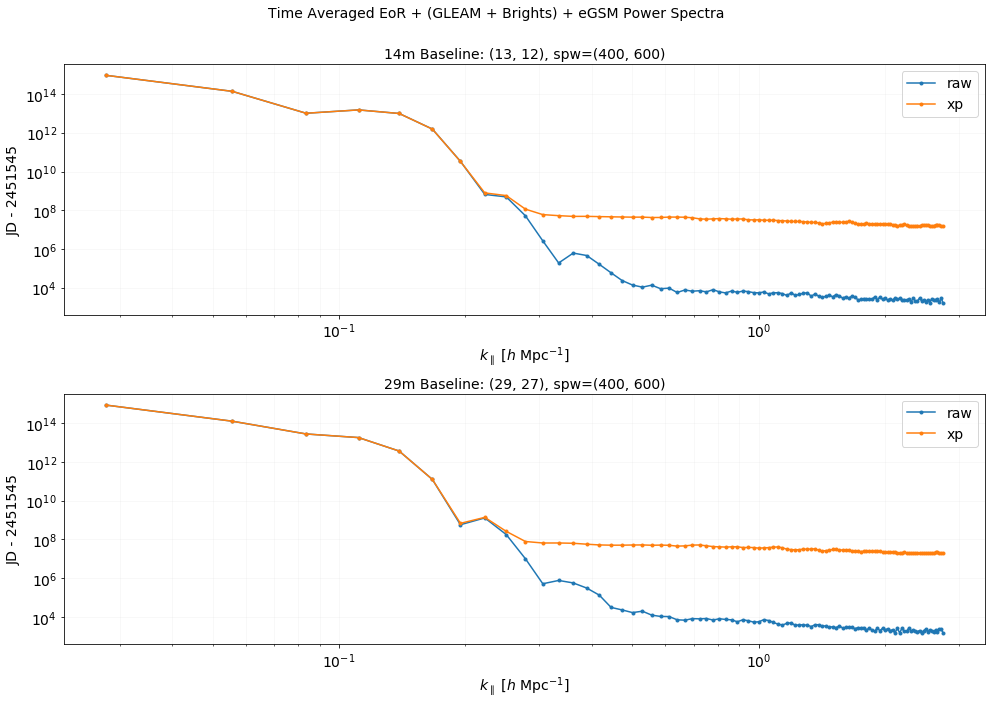

In [24]:
fig = figure(31, figsize=(14, 10))
# fig = figure(31)
clf()
nspws = 1
nrows, ncols = 2, nspws
gs = GridSpec(nrows, ncols)
axs = [[fig.add_subplot(gs[i, j]) for i in range(nrows)] for j in range(ncols)]
labels = ['Sum + XP']
time_avg = True

for i_spw in range(ncols):
    axs[i_spw][0].set_title('14m Baseline: {}, spw={}'.format(blps[0][0], spws[i_spw]), fontsize=14)
    axs[i_spw][1].set_title('29m Baseline: {}, spw={}'.format(blps[1][0], spws[i_spw]), fontsize=14)
    for ax in axs[i_spw]:
        ax.set_ylabel('JD - 2451545')
        ax.grid(which='both', alpha=0.1)
        ax.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]')
    i_f = 1
    label = labels[0]
    extent_14 = [kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size].min(), kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size].max(),
                 uvd.time_array[-1] - 2451545, uvd.time_array[0] - 2451545]
    extent_29 = [kparas_xp_29m[i_spw][i_f][:spectra_xp_29m[i_spw][i_f].size].min(), kparas_xp_29m[i_spw][i_f][:spectra_xp_29m[i_spw][i_f].size].max(),
                 uvd.time_array[-1] - 2451545, uvd.time_array[0] - 2451545]

    flags_xp_14m = np.ones_like(spectra_xp_14m[i_spw][i_f], dtype=int)
    flags_xp_29m = np.ones_like(spectra_xp_29m[i_spw][i_f], dtype=int)
    flags_xp_14m[zero_int_flags_1213] = 0.0
    flags_xp_29m[zero_int_flags_2927] = 0.0
    
    if time_avg:
        labels = ['raw', 'xp']
        for i_f in range(len(spectra_xp_14m[i_spw])):
            avg_spectra_xp_14m = np.mean(spectra_xp_14m[i_spw][i_f][flags_xp_14m[:, 0].astype('bool')], axis=0)
            avg_spectra_xp_29m = np.mean(spectra_xp_29m[i_spw][i_f][flags_xp_29m[:, 0].astype('bool')], axis=0)
            axs[i_spw][0].loglog(kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size], np.abs(avg_spectra_xp_14m), '.-', label=labels[i_f])
            axs[i_spw][1].loglog(kparas_xp_29m[i_spw][i_f][:spectra_xp_29m[i_spw][i_f].size], np.abs(avg_spectra_xp_29m), '.-', label=labels[i_f])
        axs[i_spw][0].legend(loc='upper right')
        axs[i_spw][1].legend(loc='upper right')
    else:
        im_14 = axs[i_spw][0].imshow(np.log10(np.abs(spectra_xp_14m[i_spw][i_f])) / flags_xp_14m,
                                     extent=extent_14, aspect='auto', origin='upper')
        fig.colorbar(im_14, ax=axs[i_spw][0], label=r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
        axs[i_spw][0].set_xscale('log')

        im_29 = axs[i_spw][1].imshow(np.log10(np.abs(spectra_xp_29m[i_spw][i_f])) / flags_xp_29m,
                                     extent=extent_29, aspect='auto', origin='upper')
        fig.colorbar(im_29, ax=axs[i_spw][1], label=r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
        axs[i_spw][1].set_xscale('log')

gs.tight_layout(fig);
gs.update(top=0.9)
fig_title = 'EoR + (GLEAM + Brights) + eGSM Power Spectra'
if time_avg:
    fig_title = 'Time Averaged ' + fig_title
else:
    fig_title += '\n{}'.format(os.path.basename(vis_files[i_f]))
fig.suptitle(fig_title, fontsize=14);

In [287]:
fig = make_fig(figsize=(14, 10), fignum=32)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1.8956642799891559 16.2270634436933


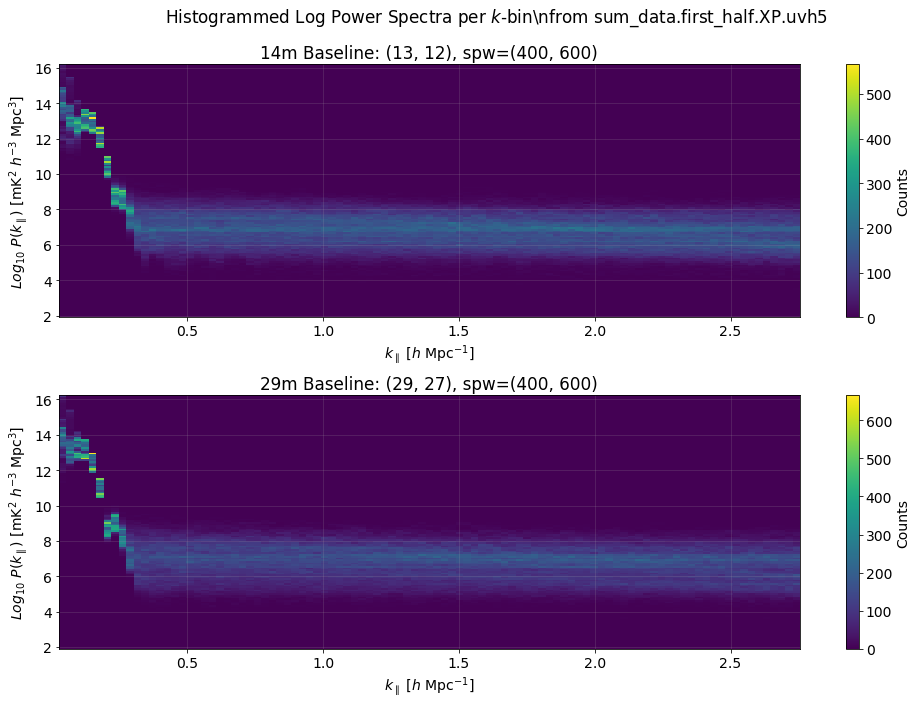

In [49]:
fig = figure(32, figsize=(14, 10))
# fig = figure(32)
clf()
nspws = 1
nrows, ncols = 2, nspws
gs = GridSpec(nrows, ncols)
axs = [[fig.add_subplot(gs[i, j]) for i in range(nrows)] for j in range(ncols)]

for i_spw in range(ncols):
    axs[i_spw][0].set_title('14m Baseline: {}, spw={}'.format(blps[0][0], spws[i_spw]))
    axs[i_spw][1].set_title('29m Baseline: {}, spw={}'.format(blps[1][0], spws[i_spw]))
    for ax in axs[i_spw]:
        ax.set_ylabel(r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
        ax.grid(which='major', alpha=0.2)
        ax.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]')
    i_f = 1
    label = labels[0]

    flags_xp_14m = np.ones_like(spectra_xp_14m[i_spw][i_f], dtype=int)
    flags_xp_29m = np.ones_like(spectra_xp_29m[i_spw][i_f], dtype=int)
    flags_xp_14m[zero_int_flags_1213] = 0.0
    flags_xp_29m[zero_int_flags_2927] = 0.0
    
    func = np.real
    min_bin_edge = np.min([np.nanmin(np.log10(func(spectra_xp_14m[i_spw][i_f][flags_xp_14m[:, 0].astype('bool')]))),
                           np.nanmin(np.log10(func(spectra_xp_29m[i_spw][i_f][flags_xp_14m[:, 0].astype('bool')])))])
    max_bin_edge = np.max([np.nanmax(np.log10(func(spectra_xp_14m[i_spw][i_f][flags_xp_29m[:, 0].astype('bool')]))),
                           np.nanmax(np.log10(func(spectra_xp_29m[i_spw][i_f][flags_xp_29m[:, 0].astype('bool')])))])
    print(min_bin_edge, max_bin_edge)
    nbins = 151
    bin_edges = np.linspace(min_bin_edge, max_bin_edge, nbins)
    bin_centers = np.array([(bin_edges[i + 1] - bin_edges[i])/2 for i in range(nbins - 1)])
    
    hist_data_14m = np.zeros((bin_centers.size, kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size].size))
    hist_data_29m = np.zeros((bin_centers.size, kparas_xp_29m[i_spw][i_f][:spectra_xp_29m[i_spw][i_f].size].size))
    for i_col in range(spectra_xp_14m[i_spw][i_f].shape[1]):
        hist_data_14m[:, i_col] = np.histogram(np.log10(func(spectra_xp_14m[i_spw][i_f][flags_xp_14m[:, 0].astype('bool'), i_col])),
                                               bins=bin_edges)[0]
        hist_data_29m[:, i_col] = np.histogram(np.log10(func(spectra_xp_29m[i_spw][i_f][flags_xp_29m[:, 0].astype('bool'), i_col])),
                                               bins=bin_edges)[0]
    
    extent = [kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size].min(), kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size].max(),
              min_bin_edge, max_bin_edge]
    
    im_14 = axs[i_spw][0].imshow(hist_data_14m,
                                 extent=extent, aspect='auto', origin='lower')
    fig.colorbar(im_14, ax=axs[i_spw][0], label='Counts')
    
    im_29 = axs[i_spw][1].imshow(hist_data_29m,
                                 extent=extent, aspect='auto', origin='lower')
    fig.colorbar(im_29, ax=axs[i_spw][1], label='Counts')

gs.tight_layout(fig);
gs.update(top=0.9)
fig_title = r'Histogrammed Log Power Spectra per $k$-bin\nfrom {}'.format(os.path.basename(vis_files[i_f]))
fig.suptitle(fig_title);

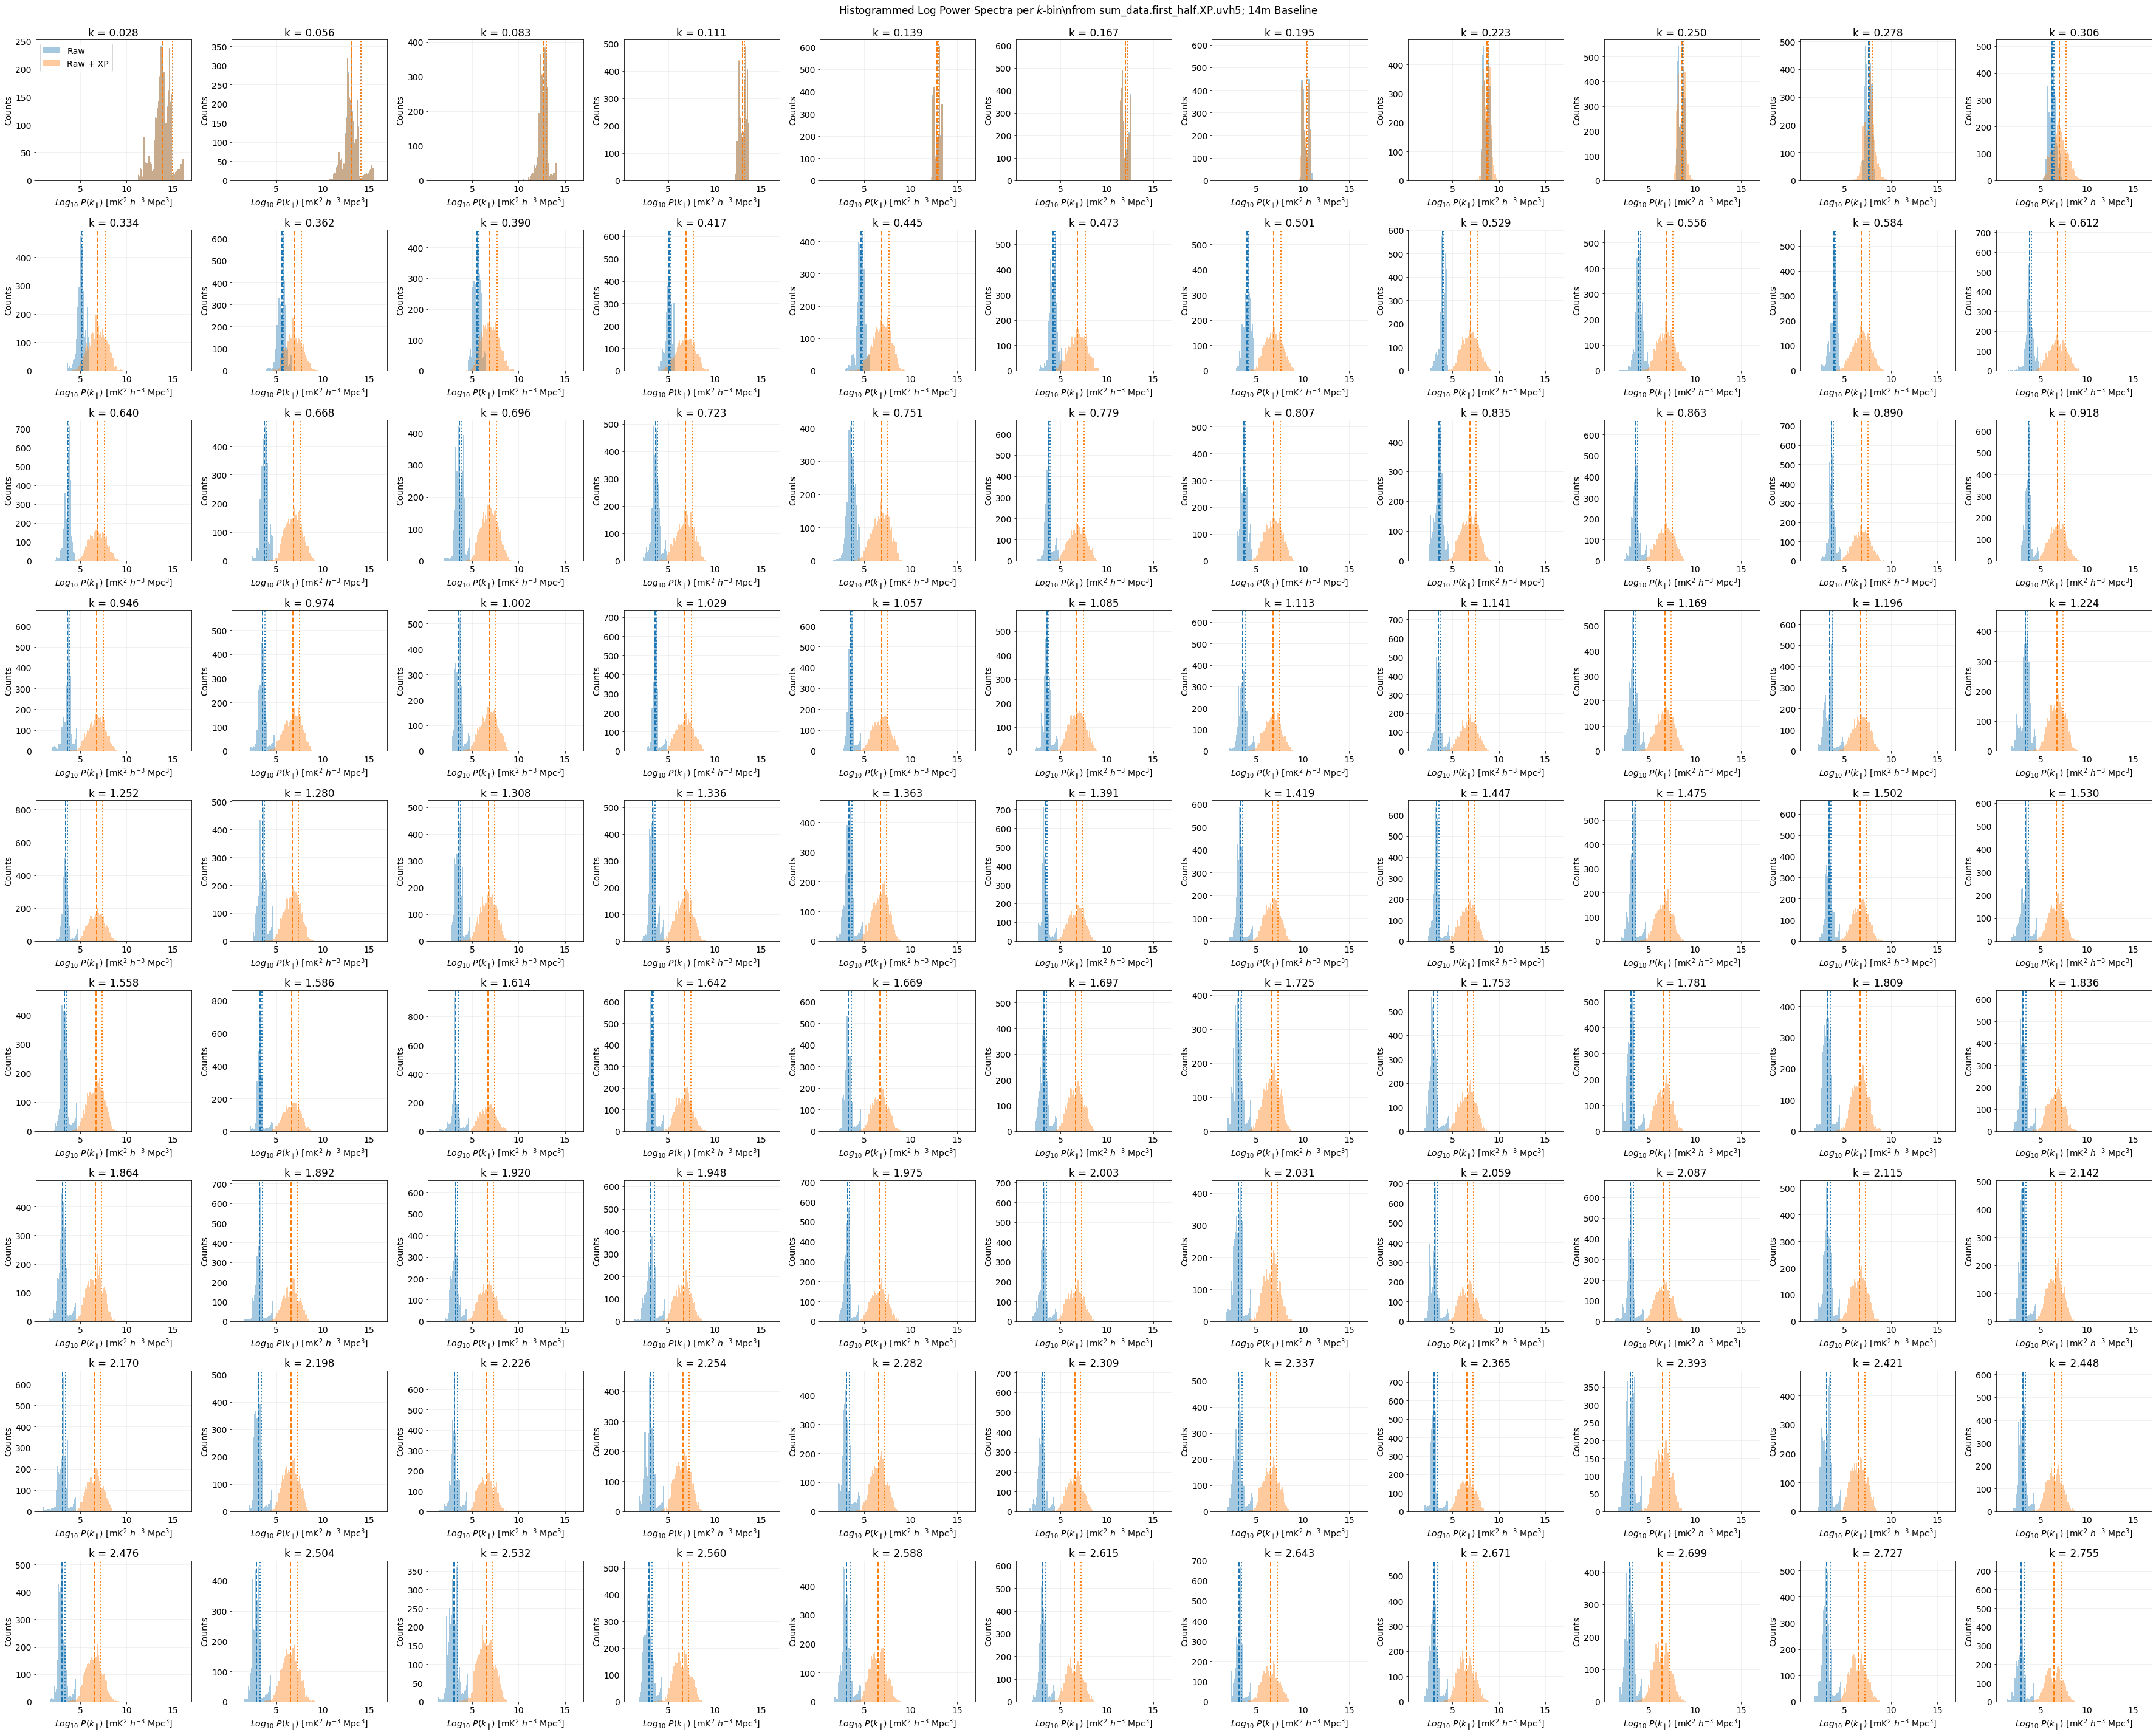

In [32]:
nplots = len(kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size])
nrows = int(np.sqrt(nplots))
ncols = int(np.ceil(float(nplots) / nrows))
nempty = nrows*ncols - nplots

plot_size = 4.5
fig_14 = figure(32, figsize=(ncols * plot_size, nrows * plot_size))
i_spw = 0
gs = GridSpec(nrows, ncols)
axs_14 = [fig_14.add_subplot(gs[i]) for i in range(nplots - nempty)]

i_f = 1

flags_xp_14m = np.ones_like(spectra_xp_14m[i_spw][i_f], dtype=int)
flags_xp_14m[zero_int_flags_1213] = 0.0

func = np.real
min_bin_edge = np.min([np.nanmin(np.log10(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool')]))),
                       np.nanmin(np.log10(func(spectra_xp_29m[i_spw][0][flags_xp_29m[:, 0].astype('bool')]))),
                       np.nanmin(np.log10(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool')]))),
                       np.nanmin(np.log10(func(spectra_xp_29m[i_spw][1][flags_xp_29m[:, 0].astype('bool')])))])
max_bin_edge = np.max([np.nanmax(np.log10(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool')]))),
                       np.nanmax(np.log10(func(spectra_xp_29m[i_spw][0][flags_xp_29m[:, 0].astype('bool')]))),
                       np.nanmax(np.log10(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool')]))),
                       np.nanmax(np.log10(func(spectra_xp_29m[i_spw][1][flags_xp_29m[:, 0].astype('bool')])))])

nbins = 151
bin_edges = np.linspace(min_bin_edge, max_bin_edge, nbins)
bin_centers = np.array([(bin_edges[i + 1] - bin_edges[i])/2 for i in range(nbins - 1)])

for i_plot in range(nplots - nempty):
    axs_14[i_plot].set_title('14m Baseline: {}, spw={}'.format(blps[0][0], spws[i_spw]))

    # Plot histograms
    axs_14[i_plot].hist(np.log10(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool'), i_plot])),
                               bins=bin_edges, alpha=0.4, label='Raw')    
    axs_14[i_plot].hist(np.log10(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool'), i_plot])),
                               bins=bin_edges, alpha=0.4, label='Raw + XP')
    
    # Plot means of histograms
    curr_ylim = axs_14[i_plot].get_ylim()
    axs_14[i_plot].vlines(np.mean(np.log10(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool'), i_plot]))),
                          curr_ylim[0], curr_ylim[1], color='C0', linestyle='--', lw=2)
    axs_14[i_plot].vlines(np.mean(np.log10(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool'), i_plot]))),
                          curr_ylim[0], curr_ylim[1], color='C1', linestyle='--', lw=2)
    axs_14[i_plot].vlines(np.log10(np.mean(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool'), i_plot]))),
                          curr_ylim[0], curr_ylim[1], color='C0', linestyle=':', lw=2)
    axs_14[i_plot].vlines(np.log10(np.mean(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool'), i_plot]))),
                          curr_ylim[0], curr_ylim[1], color='C1', linestyle=':', lw=2)
    axs_14[i_plot].set_ylim(curr_ylim)
    
    axs_14[i_plot].set_title('k = {:.3f}'.format(kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size][i_plot], decimals=3))

for ax in axs_14:
    ax.set_xlabel(r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
    ax.grid(which='major', alpha=0.2)
    ax.set_ylabel('Counts')

axs_14[0].legend(loc='upper left')

gs.tight_layout(fig_14)
# gs.tight_layout(fig_29)
gs.update(top=0.96)

fig_title = r'Histogrammed Log Power Spectra per $k$-bin\nfrom {}; 14m Baseline'.format(os.path.basename(vis_files[i_f]))
fig_14.suptitle(fig_title);

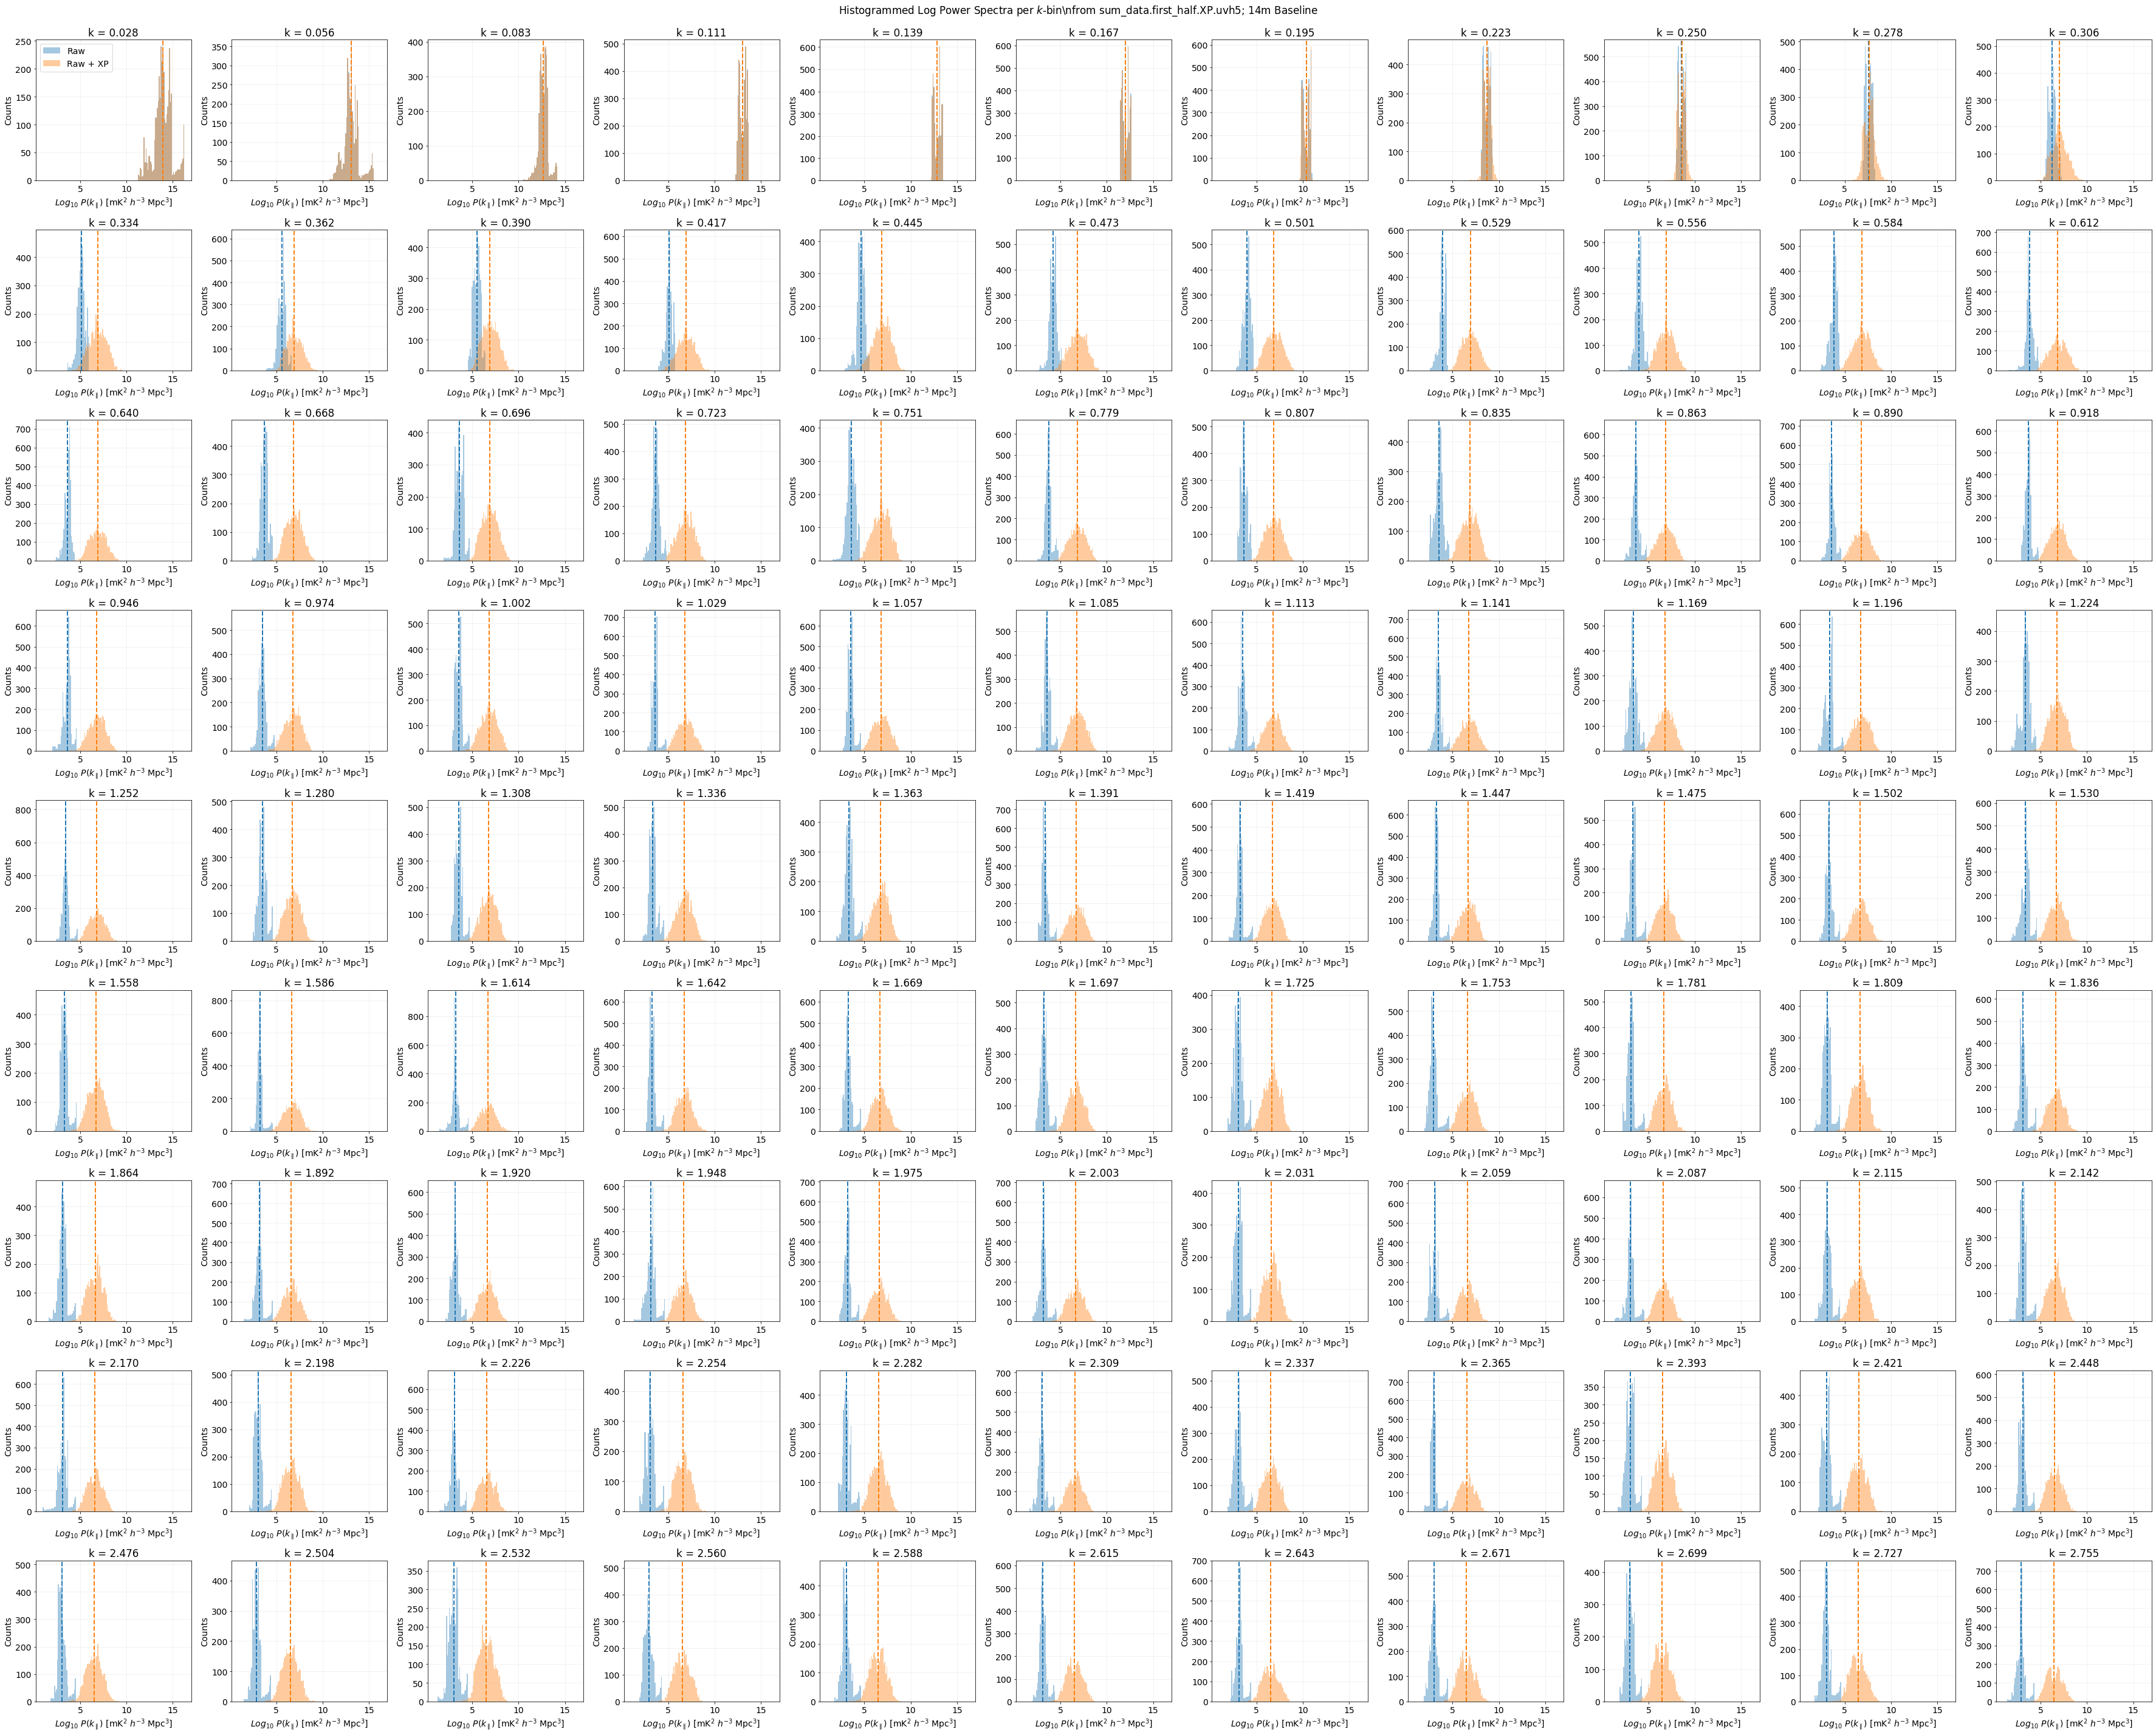

In [31]:
nplots = len(kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size])
nrows = int(np.sqrt(nplots))
ncols = int(np.ceil(float(nplots) / nrows))
nempty = nrows*ncols - nplots

plot_size = 4.5
fig_14 = figure(32, figsize=(ncols * plot_size, nrows * plot_size))
# fig_29 = figure(33, figsize=(ncols * plot_size, nrows * plot_size))
i_spw = 0
gs = GridSpec(nrows, ncols)
axs_14 = [fig_14.add_subplot(gs[i]) for i in range(nplots - nempty)]
# axs_29 = [fig_29.add_subplot(gs[i]) for i in range(nplots - nempty)]

i_f = 1

flags_xp_14m = np.ones_like(spectra_xp_14m[i_spw][i_f], dtype=int)
# flags_xp_29m = np.ones_like(spectra_xp_29m[i_spw][i_f], dtype=int)
flags_xp_14m[zero_int_flags_1213] = 0.0
# flags_xp_29m[zero_int_flags_2927] = 0.0

func = np.real
min_bin_edge = np.min([np.nanmin(np.log10(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool')]))),
                       np.nanmin(np.log10(func(spectra_xp_29m[i_spw][0][flags_xp_29m[:, 0].astype('bool')]))),
                       np.nanmin(np.log10(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool')]))),
                       np.nanmin(np.log10(func(spectra_xp_29m[i_spw][1][flags_xp_29m[:, 0].astype('bool')])))])
max_bin_edge = np.max([np.nanmax(np.log10(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool')]))),
                       np.nanmax(np.log10(func(spectra_xp_29m[i_spw][0][flags_xp_29m[:, 0].astype('bool')]))),
                       np.nanmax(np.log10(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool')]))),
                       np.nanmax(np.log10(func(spectra_xp_29m[i_spw][1][flags_xp_29m[:, 0].astype('bool')])))])

nbins = 151
bin_edges = np.linspace(min_bin_edge, max_bin_edge, nbins)
bin_centers = np.array([(bin_edges[i + 1] - bin_edges[i])/2 for i in range(nbins - 1)])

for i_plot in range(nplots - nempty):
    axs_14[i_plot].set_title('14m Baseline: {}, spw={}'.format(blps[0][0], spws[i_spw]))
#     axs_29[i_plot].set_title('29m Baseline: {}, spw={}'.format(blps[1][0], spws[i_spw]))

    # Plot histograms
    axs_14[i_plot].hist(np.log10(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool'), i_plot])),
                               bins=bin_edges, alpha=0.4, label='Raw')    
    axs_14[i_plot].hist(np.log10(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool'), i_plot])),
                               bins=bin_edges, alpha=0.4, label='Raw + XP')
    
    # Plot means of histograms
    curr_ylim = axs_14[i_plot].get_ylim()
    axs_14[i_plot].vlines(np.mean(np.log10(func(spectra_xp_14m[i_spw][0][flags_xp_14m[:, 0].astype('bool'), i_plot]))),
                          curr_ylim[0], curr_ylim[1], color='C0', linestyle='--', lw=2)
    axs_14[i_plot].vlines(np.mean(np.log10(func(spectra_xp_14m[i_spw][1][flags_xp_14m[:, 0].astype('bool'), i_plot]))),
                          curr_ylim[0], curr_ylim[1], color='C1', linestyle='--', lw=2)
    axs_14[i_plot].set_ylim(curr_ylim)
    
    axs_14[i_plot].set_title('k = {:.3f}'.format(kparas_xp_14m[i_spw][i_f][:spectra_xp_14m[i_spw][i_f].size][i_plot], decimals=3))

#     axs_29[i_plot].hist(np.log10(func(spectra_xp_29m[i_spw][i_f][flags_xp_29m[:, 0].astype('bool'), i_plot])),
#                                bins=bin_edges)
#     axs_29[i_plot].set_title('k = {:.3f}'.format(kparas_xp_29m[i_spw][i_f][:spectra_xp_29m[i_spw][i_f].size][i_plot], decimals=3))

for ax in axs_14:
    ax.set_xlabel(r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
    ax.grid(which='major', alpha=0.2)
    ax.set_ylabel('Counts')

# for ax in axs_29:
#     ax.set_xlabel(r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
#     ax.grid(which='major', alpha=0.2)
#     ax.set_ylabel('Counts')

axs_14[0].legend(loc='upper left')

# handles, labels = axs_14[0].get_legend_handles_labels()
# fig_14.legend(handles, labels, loc='upper center', ncol=2)

gs.tight_layout(fig_14)
# gs.tight_layout(fig_29)
gs.update(top=0.96)

fig_title = r'Histogrammed Log Power Spectra per $k$-bin\nfrom {}; 14m Baseline'.format(os.path.basename(vis_files[i_f]))
fig_14.suptitle(fig_title);
# fig_29.suptitle(fig_title);

1. Plot the mean (computed in linear and log units to compare)
2. Plot histograms for with and without fully flagged integrations

<br>

___

# Delay Solutions and Power Spectra

In [196]:
delay_solution_files = [os.path.join(data_path,
                          'pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.XD.uvh5'),
                        os.path.join(data_path,
                          'pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.second_half.XD.uvh5')]

uvd_xd = UVData()
uvd_xd.read(delay_solution_files[0])
print(uvd_xd.data_array.shape)

Telescope RIMEz calculation is not in known_telescopes.


(257664, 1, 1024, 4)


In [197]:
fig = make_fig(figsize=(14, 10), fignum=21)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

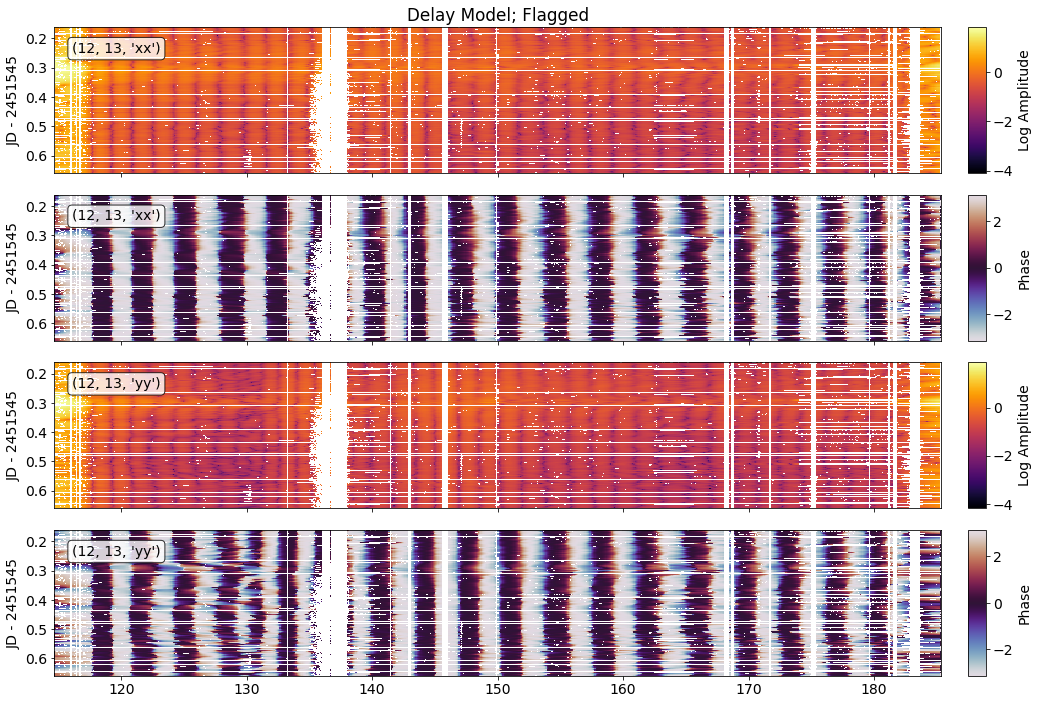

In [332]:
fig = figure(21, figsize=(16, 10))
# fig = figure(21)
clf()
blxx = ((12, 13, 'xx'))
blyy = ((12, 13, 'yy'))
freq_inds = [flag_nchan_low, -flag_nchan_high]
# freq_inds = [400, 600]
plot_freqs = uvd_xd.freq_array[0, freq_inds[0]:freq_inds[1]]
extent = [plot_freqs[0] / 1.0e6, plot_freqs[-1] / 1.0e6,
          uvd_xd.time_array[-1] - 2451545, uvd_xd.time_array[0] - 2451545]

flags = uvd_xd.get_flags(blxx)[:, freq_inds[0]:freq_inds[1]]
# flags = np.zeros_like(uvd_xd.get_flags(blxx)[:, freq_inds[0]:freq_inds[1]])
fig_title = 'Delay Model'
if np.sum(flags) == 0:
    fig_title += '; Unflagged'
else:
    fig_title += '; Flagged'

waterfall_column([np.abs(uvd_xd.get_data(blxx)[:, freq_inds[0]:freq_inds[1]]),
                  np.angle(uvd_xd.get_data(blxx)[:, freq_inds[0]:freq_inds[1]]),
                  np.abs(uvd_xd.get_data(blyy)[:, freq_inds[0]:freq_inds[1]]),
                  np.angle(uvd_xd.get_data(blyy)[:, freq_inds[0]:freq_inds[1]])],
                 [flags] * 4,
                 [blxx, blxx, blyy, blyy],
                 extents = [extent] * 4,
                 clabels = ['Amplitude', 'Phase'] * 2,
                 cmaps = ['inferno', 'twilight'] * 2,
                 ylabel = 'JD - 2451545',
                 logs = [True, False, True, False],
                 fignum=21,
                 fig_title=fig_title);

## Calculate delay solution power spectra

In [195]:
spws = [(400, 600), (475,625), (600, 800)]
blps = [((13,12),(13,12)),((29,27),(29,27))]

data_path = '/users/jburba/data/jburba/hera-validation/test-series/3/'
vis_files = [os.path.join(data_path,
                          'pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.XD.uvh5'),
             os.path.join(data_path,
                          'pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.second_half.XD.uvh5')]
print('Visibility Files:\n' + '-'*17)
for fn in vis_files:
    print(fn)
    
if len(spws) == 1:
    pspec_files = [fn.replace('.uvh5', '.spw_{}-{}.psc'.format(spws[0][0], spws[0][1])) for fn in vis_files]
else:
    pspec_files = [fn.replace('.uvh5', '.mult_spws_v4.psc') for fn in vis_files]
print('\nPspec Files:\n' + '-'*12)
for fn in pspec_files:
    print(fn)

Visibility Files:
-----------------
/users/jburba/data/jburba/hera-validation/test-series/3/pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.XD.uvh5
/users/jburba/data/jburba/hera-validation/test-series/3/pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.second_half.XD.uvh5

Pspec Files:
------------
/users/jburba/data/jburba/hera-validation/test-series/3/pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.XD.mult_spws_v4.psc
/users/jburba/data/jburba/hera-validation/test-series/3/pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.second_half.XD.mult_spws_v4.psc


In [58]:
for vis_file, pspec_file in zip(vis_files, pspec_files):
    print("Extracting spectrum from {}".format(os.path.basename(vis_file)))
    calc_pspec(vis_file, pspec_file, spws, blps)

Extracting spectrum from hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.XD.uvh5


Telescope RIMEz calculation is not in known_telescopes.


Vis units = Jy
Cannot convert dset 1 Jy -> mK because vis_units = mK
Opening /users/jburba/data/jburba/hera-validation/test-series/3/pspec_processing/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.first_half.XD.mult_spws_v4.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((13, 12), (13, 12))
pol: (1, 1)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((29, 27), (29, 27))
pol: (1, 1)
 which may lead to normalization instabilities.
  Building q_hat...


divide by zero encountered in true_divide


  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (475, 625)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((13, 12), (13, 12))
pol: (1, 1)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((29, 27), (29, 27))
pol: (1, 1)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (600, 800)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((13, 12), (13, 12))
pol: (1, 1)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((29, 27), (29, 27))
pol: (1, 1)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying sc

In [210]:
avg = False
spectra_xd_14m, kparas_xd_14m = [], []
for i_spw in range(len(spws)):
    key = (i_spw, blps[0], 'pI')
    spectra = []
    kparas = []
    for pspec_file in pspec_files:
        output = get_pspec(pspec_file, key, avg=avg)
        spectra.append(output[0])
        kparas.append(output[1])
    spectra_xd_14m.append(spectra)
    kparas_xd_14m.append(kparas)

spectra_xd_29m, kparas_xd_29m = [], []
for i_spw in range(len(spws)):
    key = (i_spw, blps[1], 'pI')
    spectra = []
    kparas = []
    for pspec_file in pspec_files:
        output = get_pspec(pspec_file, key, avg=avg)
        spectra.append(output[0])
        kparas.append(output[1])
    spectra_xd_29m.append(spectra)
    kparas_xd_29m.append(kparas)

## Delay model power spectra

In [212]:
fig = make_fig(figsize=(14, 10), fignum=22)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [215]:
fig = figure(22)
clf()
nspws = 1
nrows, ncols = 2, nspws
gs = GridSpec(nrows, ncols)
axs = [[fig.add_subplot(gs[i, j]) for i in range(nrows)] for j in range(ncols)]
labels = ['Sum + XP']
time_avg = True

for i_spw in range(ncols):
    axs[i_spw][0].set_title('14m Baseline: {}, spw={}'.format(blps[0][0], spws[i_spw]), fontsize=10)
    axs[i_spw][1].set_title('29m Baseline: {}, spw={}'.format(blps[1][0], spws[i_spw]), fontsize=10)
    for ax in axs[i_spw]:
        ax.set_ylabel('JD - 2451545')
        ax.grid(which='major', alpha=0.2)
        ax.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]')
    i_f = 0
    label = labels[0]
    extent_14 = [kparas_xd_14m[i_spw][i_f][:spectra_xd_14m[i_spw][i_f].size].min(), kparas_xd_14m[i_spw][i_f][:spectra_xd_14m[i_spw][i_f].size].max(),
                 uvd.time_array[-1] - 2451545, uvd.time_array[0] - 2451545]
    extent_29 = [kparas_xd_29m[i_spw][i_f][:spectra_xd_29m[i_spw][i_f].size].min(), kparas_xd_29m[i_spw][i_f][:spectra_xd_29m[i_spw][i_f].size].max(),
                 uvd.time_array[-1] - 2451545, uvd.time_array[0] - 2451545]

    flags_xd_14m = np.ones_like(spectra_xd_14m[i_spw][i_f], dtype=int)
    flags_xd_29m = np.ones_like(spectra_xd_29m[i_spw][i_f], dtype=int)
    flags_xd_14m[zero_int_flags_1213] = 0.0
    flags_xd_29m[zero_int_flags_2927] = 0.0
    
    if time_avg:
        avg_spectra_xd_14m = np.mean(spectra_xd_14m[i_spw][i_f][flags_xd_14m[:, 0].astype('bool')], axis=0)
        avg_spectra_xd_29m = np.mean(spectra_xd_29m[i_spw][i_f][flags_xd_29m[:, 0].astype('bool')], axis=0)
        axs[i_spw][0].loglog(kparas_xd_14m[i_spw][i_f][:spectra_xd_14m[i_spw][i_f].size], np.abs(avg_spectra_xd_14m), '.-', label=label)
        axs[i_spw][1].loglog(kparas_xd_29m[i_spw][i_f][:spectra_xd_29m[i_spw][i_f].size], np.abs(avg_spectra_xd_29m), '.-', label=label)
    else:
        im_14 = axs[i_spw][0].imshow(np.log10(np.abs(spectra_xd_14m[i_spw][i_f])) / flags_14m,
                                     extent=extent_14, aspect='auto', origin='upper')
        fig.colorbar(im_14, ax=axs[i_spw][0], label=r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
        axs[i_spw][0].set_xscale('log')

        im_29 = axs[i_spw][1].imshow(np.log10(np.abs(spectra_xd_29m[i_spw][i_f])) / flags_29m,
                                     extent=extent_29, aspect='auto', origin='upper')
        fig.colorbar(im_29, ax=axs[i_spw][1], label=r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
        axs[i_spw][1].set_xscale('log')

gs.tight_layout(fig);
gs.update(top=0.9)
fig_title = 'Residual Power Spectra\n{} - {}'.format(os.path.basename(vis_files[0]), os.path.basename(vis_files[1]))
if time_avg:
    fig_title = 'Time Averaged ' + fig_title
fig.suptitle(fig_title, fontsize=10);

Data has no positive values, and therefore cannot be log-scaled.
Data has no positive values, and therefore cannot be log-scaled.


<br>

___

# Residuals and power spectra

In [9]:
bls = [(13, 12), (29, 27)]
flag_nchan_low, flag_nchan_high = 150, 150
chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]

In [34]:
try:
    del(vI_residuals)
    print("Deleted existing vI_residuals")
except:
    print("Nothing to delete")
blpairs = [((13,12),(13,12)),((29,27),(29,27))]
vis_files = [os.path.join(data_path, raw_datafile), os.path.join(data_path, p_datafile)]
vI_residuals = get_VI_residual_data(vis_files, blpairs=blpairs)

Nothing to delete
Reading data from /users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.uvh5


Telescope RIMEz calculation is not in known_telescopes.


(8052, 1, 924, 4)
Reading data from /users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.XP.uvh5
(8052, 1, 924, 4)


In [206]:
fig = make_fig(figsize=(14, 6), fignum=11)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

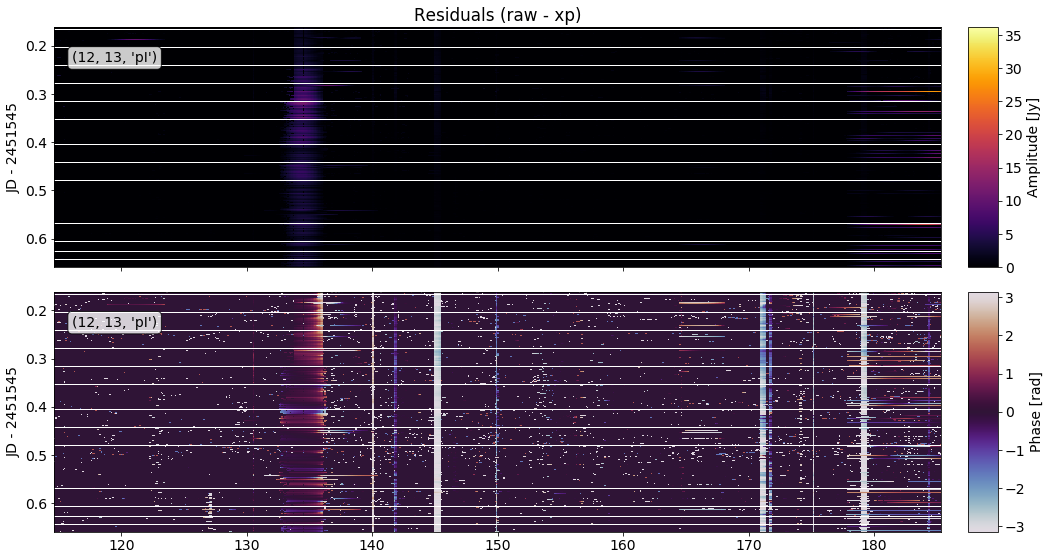

In [43]:
fig = figure(11, figsize=(16, 8))
# fig = figure(11)
# fig.canvas.layout.height = '6in'
clf()
bl = ((12, 13, 'pI'))
freq_inds = [flag_nchan_low, -flag_nchan_high]
plot_freqs = uvd_xp.freq_array[0, freq_inds[0]:freq_inds[1]]
extent = [plot_freqs[0] / 1.0e6, plot_freqs[-1] / 1.0e6,
          vI_residuals.time_array[-1] - 2451545, vI_residuals.time_array[0] - 2451545]

flags = vI_residuals.get_flags(bl)
flags[zero_int_flags_1213] = 1.0
# flags = uvd_xp.get_flags((bl[0], bl[1], 'xx'))[:, 50:-50]

waterfall_column([np.abs(vI_residuals.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.angle(vI_residuals.get_data(bl)[:, freq_inds[0]:freq_inds[1]])],
                 [flags[:, freq_inds[0]:freq_inds[1]]] * 2,
                 [bl] * 2,
                 extents = [extent] * 2,
                 clabels = ['Amplitude [Jy]', 'Phase [rad]'],
                 cmaps = ['inferno', 'twilight'],
                 ylabel = 'JD - 2451545',
                 logs = [False, False],
                 fignum=11,
                 fig_title='Residuals (raw - xp)');

In [137]:
fig = make_fig(figsize=(14, 12), fignum=12)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

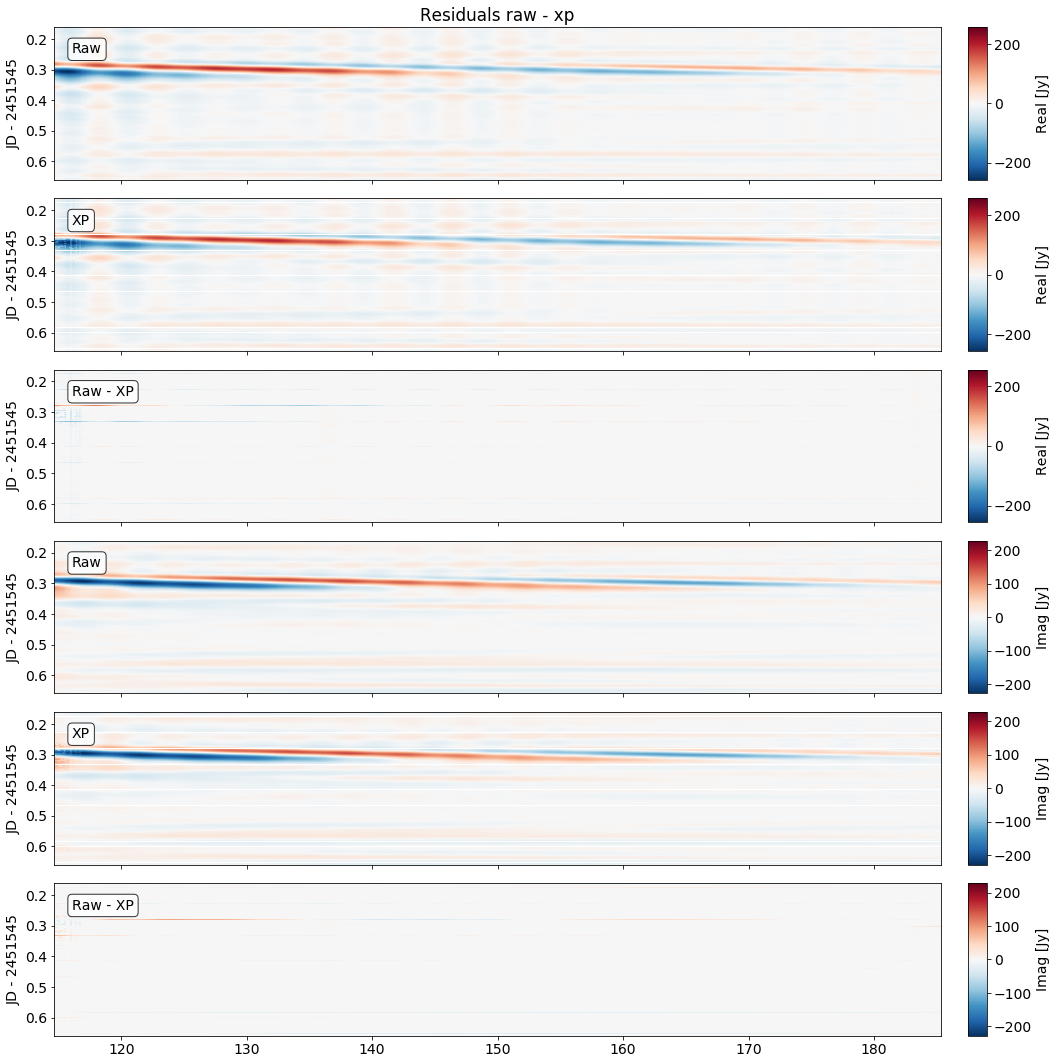

In [51]:
fig = figure(12, figsize=(16, 15))
# fig = figure(12)
clf()
bl = ((12, 13, 'xx'))
freq_inds = [flag_nchan_low, -flag_nchan_high]
plot_freqs = uvd_x.freq_array[0, freq_inds[0]:freq_inds[1]]
extent = [plot_freqs[0] / 1.0e6, plot_freqs[-1] / 1.0e6,
          uvd_raw.time_array[-1] - 2451545, uvd_raw.time_array[0] - 2451545]

data_to_plot = [np.real(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.real(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.real(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]])
                  -
                  np.real(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.imag(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.imag(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]]),
                  np.imag(uvd_raw.get_data(bl)[:, freq_inds[0]:freq_inds[1]])
                  -
                  np.imag(uvd_xp.get_data(bl)[:, freq_inds[0]:freq_inds[1]])]
clims = [(-np.max([np.abs(x).min(), np.abs(x).max()]), np.max([np.abs(x).min(), np.abs(x).max()])) for x in data_to_plot]

waterfall_column(data_to_plot,
                 [uvd_raw.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_raw.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_raw.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_xp.get_flags(bl)[:, freq_inds[0]:freq_inds[1]],
                  uvd_raw.get_flags(bl)[:, freq_inds[0]:freq_inds[1]]],
                 ['Raw', 'XP', 'Raw - XP', 'Raw', 'XP', 'Raw - XP'],
                 extents = [extent] * 6,
                 clabels = ['Real [Jy]'] * 3 + ['Imag [Jy]'] * 3,
                 cmaps = ['RdBu_r'] * 6, #+ ['twilight'] * 3,
                 clims = clims,
                 ylabel = 'JD - 2451545',
                 logs = [False, False, False, False, False, False],
                 fignum=12,
                 fig_title='Residuals raw - xp');

## Calculate residual power spectra

In [67]:
spws = [(400, 600)]
blps = [((13,12),(13,12)),((29,27),(29,27))]

data_path = '/users/jburba/data/jburba/hera-validation/test-series/3/'
vis_files = [os.path.join(data_path, raw_datafile),
             os.path.join(data_path, p_datafile)]
vis_data_paths = [vis_files]

print('Visibility Files:\n' + '-'*17)
for fn in vis_files:
    print(fn)
    
if len(spws) == 1:
    pspec_files = ['data_minus_model_residuals.spw_{}-{}.psc'.format(spws[0][0], spws[0][1]) for fn in vis_data_paths]
else:
    pspec_files = ['data_minus_model_residuals.mult_spws.psc' for fn in vis_data_paths]
print('\nPspec Files:\n' + '-'*12)
for fn in pspec_files:
    print(fn)

Visibility Files:
-----------------
/users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.uvh5
/users/jburba/data/jburba/hera-validation/test-series/3/sum_data.first_half.XP.uvh5

Pspec Files:
------------
data_minus_model_residuals.spw_400-600.psc


In [16]:
for vis_data_paths, pspec_file in zip(vis_data_paths, pspec_files):
    print("Extracting residual spectrum from {} - {}".format(os.path.basename(vis_data_paths[0]), os.path.basename(vis_data_paths[1])))
    calc_pspec_residuals(vis_data_paths, pspec_file, spws, blps)

Extracting residual spectrum from sum_data.first_half.uvh5 - sum_data.first_half.XP.uvh5
Vis units = Jy
Cannot convert dset 1 Jy -> mK because vis_units = mK
Opening data_minus_model_residuals.spw_400-600.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((13, 12), (13, 12))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((29, 27), (29, 27))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...
Storing dset0_x_dset1


In [68]:
avg = False
spectra_14m, kparas_14m = [], []
for i_spw in range(len(spws)):
    key = (i_spw, blps[0], 'pI')
    spectra = []
    kparas = []
    for pspec_file in pspec_files:
        output = get_pspec(pspec_file, key, avg=avg)
        spectra.append(output[0])
        kparas.append(output[1])
    spectra_14m.append(spectra)
    kparas_14m.append(kparas)

spectra_29m, kparas_29m = [], []
for i_spw in range(len(spws)):
    key = (i_spw, blps[1], 'pI')
    spectra = []
    kparas = []
    for pspec_file in pspec_files:
        output = get_pspec(pspec_file, key, avg=avg)
        spectra.append(output[0])
        kparas.append(output[1])
    spectra_29m.append(spectra)
    kparas_29m.append(kparas)

### Power Spectra

In [182]:
fig = make_fig(figsize=(12, 10), fignum=6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

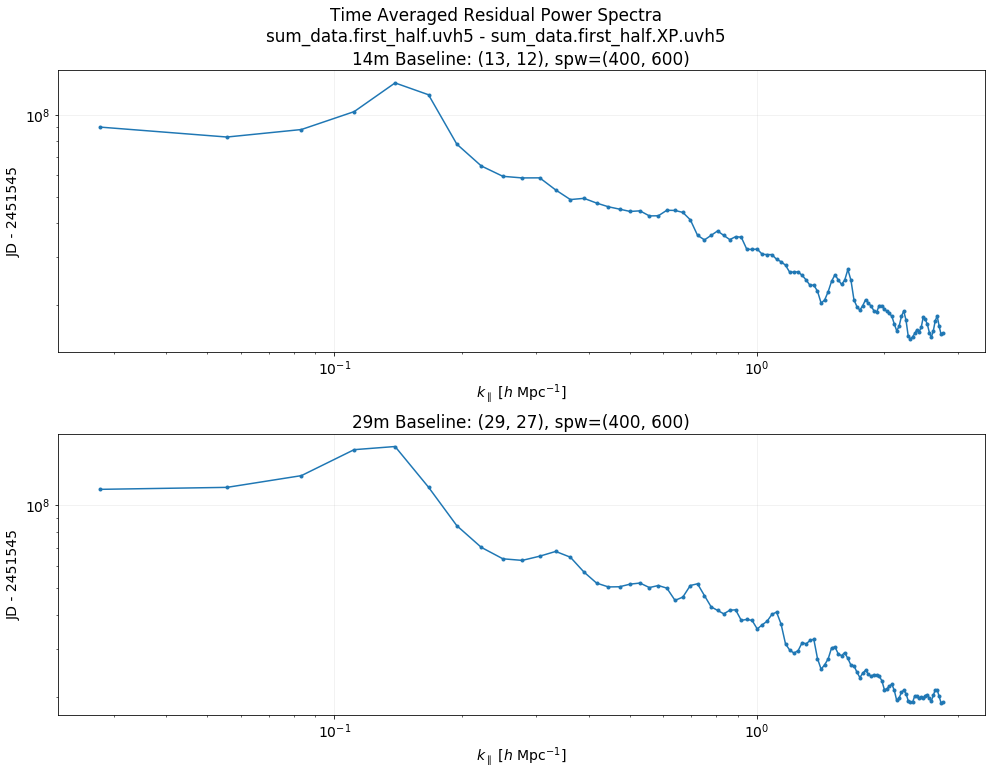

In [69]:
fig = figure(6, figsize=(14, 11))
# fig = figure(6)
clf()
nspws = 1
nrows, ncols = 2, nspws
gs = GridSpec(nrows, ncols)
axs = [[fig.add_subplot(gs[i, j]) for i in range(nrows)] for j in range(ncols)]
labels = ['Sum + XP']
time_avg = True

for i_spw in range(ncols):
    axs[i_spw][0].set_title('14m Baseline: {}, spw={}'.format(blps[0][0], spws[i_spw]))
    axs[i_spw][1].set_title('29m Baseline: {}, spw={}'.format(blps[1][0], spws[i_spw]))
    for ax in axs[i_spw]:
        ax.set_ylabel('JD - 2451545')
        ax.grid(which='major', alpha=0.2)
        ax.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]')
    i_f = 0
    label = labels[0]
    extent_14 = [kparas_14m[i_spw][i_f][:spectra_14m[i_spw][i_f].size].min(), kparas_14m[i_spw][i_f][:spectra_14m[i_spw][i_f].size].max(),
                 uvd.time_array[-1] - 2451545, uvd.time_array[0] - 2451545]
    extent_29 = [kparas_29m[i_spw][i_f][:spectra_29m[i_spw][i_f].size].min(), kparas_29m[i_spw][i_f][:spectra_29m[i_spw][i_f].size].max(),
                 uvd.time_array[-1] - 2451545, uvd.time_array[0] - 2451545]

    flags_14m = np.ones_like(spectra_14m[i_spw][i_f], dtype=int)
    flags_29m = np.ones_like(spectra_29m[i_spw][i_f], dtype=int)
    flags_14m[zero_int_flags_1213] = 0.0
    flags_29m[zero_int_flags_2927] = 0.0
    
    if time_avg:
        avg_spectra_14m = np.mean(spectra_14m[i_spw][i_f][flags_14m[:, 0].astype('bool')], axis=0)
        avg_spectra_29m = np.mean(spectra_29m[i_spw][i_f][flags_29m[:, 0].astype('bool')], axis=0)
        axs[i_spw][0].loglog(kparas_14m[i_spw][i_f][:spectra_14m[i_spw][i_f].size], np.abs(avg_spectra_14m), '.-', label=label)
        axs[i_spw][1].loglog(kparas_29m[i_spw][i_f][:spectra_29m[i_spw][i_f].size], np.abs(avg_spectra_29m), '.-', label=label)
    else:
        im_14 = axs[i_spw][0].imshow(np.log10(np.abs(spectra_14m[i_spw][i_f])) / flags_14m,
                                     extent=extent_14, aspect='auto', origin='upper')
        fig.colorbar(im_14, ax=axs[i_spw][0], label=r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
        axs[i_spw][0].set_xscale('log')

        im_29 = axs[i_spw][1].imshow(np.log10(np.abs(spectra_29m[i_spw][i_f])) / flags_29m,
                                     extent=extent_29, aspect='auto', origin='upper')
        fig.colorbar(im_29, ax=axs[i_spw][1], label=r'$Log_{10}\ P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
        axs[i_spw][1].set_xscale('log')

gs.tight_layout(fig);
gs.update(top=0.9)
fig_title = 'Residual Power Spectra\n{} - {}'.format(os.path.basename(vis_files[0]), os.path.basename(vis_files[1]))
if time_avg:
    fig_title = 'Time Averaged ' + fig_title
fig.suptitle(fig_title);

Try setting all flags to false and rerunning the power spectra

In [188]:
fig = make_fig(figsize=(12, 10), fignum=7)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'With Fully Flagged Integrations')

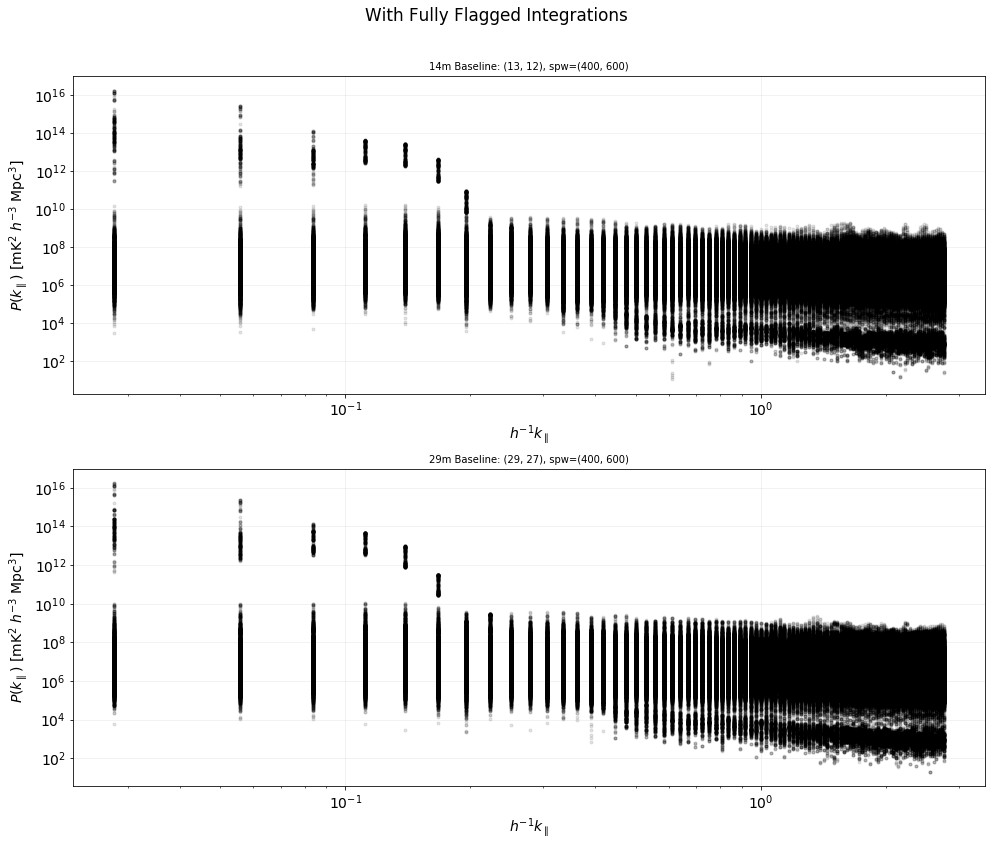

In [345]:
fig = figure(7, figsize=(14, 12))
# fig = figure(7)
clf()
nspws = 1
nrows, ncols = 2, nspws
gs = GridSpec(nrows, ncols)
axs = [[fig.add_subplot(gs[i, j]) for i in range(nrows)] for j in range(ncols)]
# labels = ['EoR', 'GLEAM + Brights', 'eGSM', 'Sum', 'Sum + XP']
labels = ['Sum', 'Sum + XP']
i_f = 0

for i_col in range(ncols):
    axs[i_col][0].set_title('14m Baseline: {}, spw={}'.format(blps[0][0], spws[i_col]), fontsize=10)
    axs[i_col][1].set_title('29m Baseline: {}, spw={}'.format(blps[1][0], spws[i_col]), fontsize=10)
    for i_int in range(spectra_14m[i_col][-1].shape[0]):
        axs[i_col][0].loglog(kparas_14m[i_col][i_f][:spectra_14m[i_col][i_f][i_int].size],
                             np.abs(spectra_14m[i_col][i_f][i_int]),
                             '.', color='k', alpha=0.1)#, label=label)
        axs[i_col][1].loglog(kparas_29m[i_col][i_f][:spectra_29m[i_col][i_f][i_int].size],
                             np.abs(spectra_29m[i_col][i_f][i_int]),
                             '.', color='k', alpha=0.1)#, label=label)

for ax in fig.axes:
    ax.set_ylabel(r'$P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
    ax.grid(which='major', alpha=0.2)
    # ax.legend(loc='lower left', fontsize=8)
    ax.set_xlabel(r'$h^{-1}k_{\parallel}$')

gs.tight_layout(fig)
gs.update(top=0.9)
fig.suptitle('With Fully Flagged Integrations')

In [190]:
fig = make_fig(figsize=(12, 10), fignum=8)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'Without Fully Flagged Integrations')

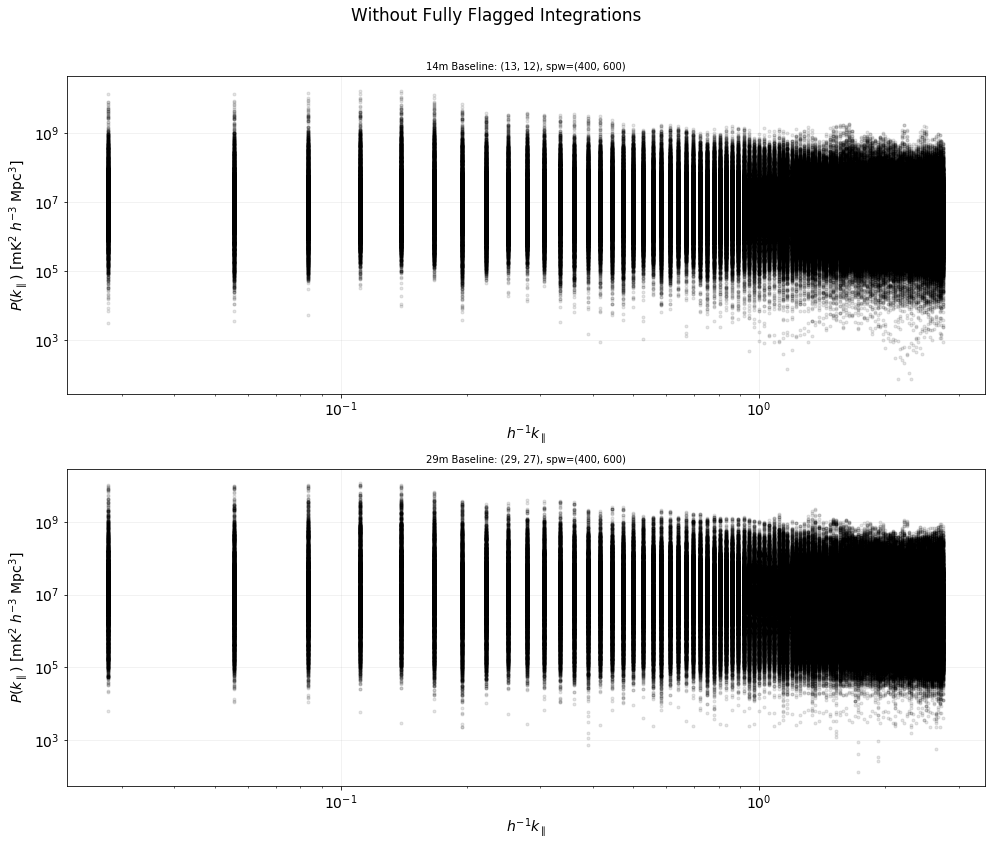

In [346]:
fig = figure(8, figsize=(14, 12))
# fig = figure(8)
clf()
nspws = 1
nrows, ncols = 2, nspws
gs = GridSpec(nrows, ncols)
axs = [[fig.add_subplot(gs[i, j]) for i in range(nrows)] for j in range(ncols)]
# labels = ['EoR', 'GLEAM + Brights', 'eGSM', 'Sum', 'Sum + XP']
labels = ['Sum', 'Sum + XP']

i_f = 0

for i_spw in range(ncols):
    axs[i_spw][0].set_title('14m Baseline: {}, spw={}'.format(blps[0][0], spws[i_spw]), fontsize=10)
    axs[i_spw][1].set_title('29m Baseline: {}, spw={}'.format(blps[1][0], spws[i_spw]), fontsize=10)
    flags_14m = np.ones_like(spectra_14m[i_spw][i_f], dtype=int)
    flags_29m = np.ones_like(spectra_29m[i_spw][i_f], dtype=int)
    flags_14m[zero_int_flags_1213] = 0.0
    flags_29m[zero_int_flags_2927] = 0.0
    for i_int in range(spectra_14m[i_spw][-1].shape[0]):
        if not flags_14m[i_int][0] == 0.0:
            axs[i_spw][0].loglog(kparas_14m[i_spw][i_f][:spectra_14m[i_spw][i_f][i_int].size],
                                 np.abs(spectra_14m[i_spw][i_f][i_int]), 
                                 '.', color='k', alpha=0.1)#, label=label)
        if not flags_29m[i_int][0] == 0.0:
            axs[i_spw][1].loglog(kparas_29m[i_spw][i_f][:spectra_29m[i_spw][i_f][i_int].size],
                                 np.abs(spectra_29m[i_spw][i_f][i_int]),
                                 '.', color='k', alpha=0.1)#, label=label)

for ax in fig.axes:
    ax.set_ylabel(r'$P(k_\parallel)$ [mK$^2$ $h^{-3}$ Mpc$^{3}$]')
    ax.grid(which='major', alpha=0.2)
    # ax.legend(loc='lower left', fontsize=8)
    ax.set_xlabel(r'$h^{-1}k_{\parallel}$')

gs.tight_layout(fig)
gs.update(top=0.9)
fig.suptitle('Without Fully Flagged Integrations')

___

In [184]:
len(kparas), len(spectra_14m[0][1])

(5, 99)

In [186]:
for i_col in range(ncols):
    for i_f, label in enumerate(labels):
        print(kparas_14m[i_col][i_f].shape, spectra_14m[i_col][i_f].shape)
        print(kparas_29m[i_col][i_f].shape, spectra_29m[i_col][i_f].shape)

(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (74,)
(99,) (74,)
(99,) (74,)
(99,) (74,)
(99,) (74,)
(99,) (74,)
(99,) (74,)
(99,) (74,)
(99,) (74,)
(99,) (74,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)
(99,) (99,)


In [61]:
fig = make_fig(figsize=(12, 9), fignum=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [81]:
fig = figure(5)
clf()
labels = ['EoR', 'GLEAM + Brights', 'eGSM', 'X', 'XP']
loglog(kparas[-1], (spectra[-2].real - spectra[-1].real) / spectra[-2].real, '.-', label='real')
loglog(kparas[-1], (spectra[-2].imag - spectra[-1].imag) / spectra[-2].imag, '.-', label='imag')

xlabel(r'$k_{\parallel}$')
ylabel(r'$\left[ P_\tau^{X}(k_\parallel) - P_\tau^{XP}(k_\parallel) \right] / P_\tau^{X}(k_\parallel)$')
grid(which='major', alpha=0.2)
legend(loc='best', ncol=5)

divide by zero encountered in true_divide
divide by zero encountered in true_divide


In [82]:
print(spectra_14m[-2])
print(spectra_29m[-2])

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0

___  

In [13]:
import hera_cal as hc
from hera_cal import io
from collections import OrderedDict as odict

In [14]:
config = '/users/jburba/data/jburba/H1C_IDR2/pipeline/prms_preprocess_validation.yaml'
cf = hera_pspec.utils.load_config(config)
params = odict(list(cf['io'].items()) + list(cf['data'].items()) + list(cf['analysis'].items()))
assert len(params) == len(cf['io']) + len(cf['data']) + len(cf['analysis']), ""\
       "Repeated parameters found within the scope of io, data and analysis dicts"


data_template = os.path.join(params['data_root'], params['data_template'])
datafiles = glob.glob(data_template)
assert len(datafiles) > 0
print(datafiles)

['/users/jburba/data/jburba/hera-validation/test-series/3/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.uvh5']


In [95]:
if params['bls'] is None:
    uv = UVData()
    uv.read(datafiles[0], read_data=False)
    reds, lens, angs = hera_pspec.utils.get_reds(uv, pick_data_ants=False, bl_len_range=params['bl_len_range'],
                                         bl_deg_range=params['bl_deg_range'], xants=params['xants'], add_autos=True)
    bls = hera_pspec.utils.flatten(reds)
else:
    bls = params['bls']

In [107]:
reds, lens, angs = hera_pspec.utils.get_reds(uv, pick_data_ants=False, bl_len_range=params['bl_len_range'],
                                         bl_deg_range=params['bl_deg_range'], xants=params['xants'], add_autos=True)
bls_pd = hera_pspec.utils.flatten(reds)

In [108]:
print(len(bls_pd), sorted(bls_pd, key=lambda element: (element[0], element[1])))

543 [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (0, 12), (0, 15), (0, 16), (0, 18), (0, 19), (0, 22), (0, 23), (0, 25), (0, 26), (0, 29), (0, 30), (0, 32), (0, 33), (0, 35), (0, 36), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (1, 12), (1, 15), (1, 16), (1, 18), (1, 19), (1, 21), (1, 22), (1, 23), (1, 25), (1, 26), (1, 28), (1, 29), (1, 30), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 12), (2, 13), (2, 16), (2, 19), (2, 22), (2, 23), (2, 26), (2, 29), (2, 30), (2, 33), (2, 35), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 14), (3, 15), (3, 16), (3, 18), (3, 19), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 15), (4, 16), (4, 19),

In [109]:
print(len(bls), sorted(bls, key=lambda element: (element[0], element[1])))

543 [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8), (0, 9), (0, 12), (0, 15), (0, 16), (0, 18), (0, 19), (0, 22), (0, 23), (0, 25), (0, 26), (0, 29), (0, 30), (0, 32), (0, 33), (0, 35), (0, 36), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (1, 12), (1, 15), (1, 16), (1, 18), (1, 19), (1, 21), (1, 22), (1, 23), (1, 25), (1, 26), (1, 28), (1, 29), (1, 30), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 12), (2, 13), (2, 16), (2, 19), (2, 22), (2, 23), (2, 26), (2, 29), (2, 30), (2, 33), (2, 35), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 14), (3, 15), (3, 16), (3, 18), (3, 19), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 28), (3, 29), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (3, 35), (3, 36), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 15), (4, 16), (4, 19),

In [100]:
print(len(F.bls), F.bls)

64 [(3, 2), (9, 0), (9, 6), (9, 9), (12, 6), (13, 5), (13, 6), (13, 12), (14, 3), (16, 11), (19, 1), (19, 6), (20, 5), (22, 7), (23, 0), (23, 22), (24, 14), (24, 21), (25, 3), (25, 4), (26, 6), (27, 8), (27, 9), (27, 16), (27, 21), (27, 23), (28, 1), (28, 10), (28, 23), (29, 1), (29, 9), (29, 20), (29, 27), (30, 3), (30, 6), (30, 13), (30, 14), (30, 20), (31, 0), (31, 6), (31, 9), (31, 15), (31, 19), (32, 0), (32, 8), (32, 9), (32, 15), (33, 1), (33, 3), (34, 0), (34, 3), (34, 8), (34, 9), (34, 21), (34, 26), (35, 1), (35, 5), (35, 13), (35, 23), (35, 28), (36, 0), (36, 1), (36, 9), (36, 34)]


In [65]:
df = '/users/jburba/data/jburba/hera-validation/test-series/3/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.uvh5'
F = hc.delay_filter.DelayFilter(df, filetype='uvh5')

Telescope RIMEz calculation is not in known_telescopes.


In [84]:
hd = io.to_HERAData(df, filetype='uvh5')
print(hd.bls)

Telescope RIMEz calculation is not in known_telescopes.


[(3, 2, 'xx'), (3, 2, 'yy'), (3, 2, 'xy'), (3, 2, 'yx'), (9, 0, 'xx'), (9, 0, 'yy'), (9, 0, 'xy'), (9, 0, 'yx'), (9, 6, 'xx'), (9, 6, 'yy'), (9, 6, 'xy'), (9, 6, 'yx'), (9, 9, 'xx'), (9, 9, 'yy'), (9, 9, 'xy'), (9, 9, 'yx'), (12, 6, 'xx'), (12, 6, 'yy'), (12, 6, 'xy'), (12, 6, 'yx'), (13, 5, 'xx'), (13, 5, 'yy'), (13, 5, 'xy'), (13, 5, 'yx'), (13, 6, 'xx'), (13, 6, 'yy'), (13, 6, 'xy'), (13, 6, 'yx'), (13, 12, 'xx'), (13, 12, 'yy'), (13, 12, 'xy'), (13, 12, 'yx'), (14, 3, 'xx'), (14, 3, 'yy'), (14, 3, 'xy'), (14, 3, 'yx'), (16, 11, 'xx'), (16, 11, 'yy'), (16, 11, 'xy'), (16, 11, 'yx'), (19, 1, 'xx'), (19, 1, 'yy'), (19, 1, 'xy'), (19, 1, 'yx'), (19, 6, 'xx'), (19, 6, 'yy'), (19, 6, 'xy'), (19, 6, 'yx'), (20, 5, 'xx'), (20, 5, 'yy'), (20, 5, 'xy'), (20, 5, 'yx'), (22, 7, 'xx'), (22, 7, 'yy'), (22, 7, 'xy'), (22, 7, 'yx'), (23, 0, 'xx'), (23, 0, 'yy'), (23, 0, 'xy'), (23, 0, 'yx'), (23, 22, 'xx'), (23, 22, 'yy'), (23, 22, 'xy'), (23, 22, 'yx'), (24, 14, 'xx'), (24, 14, 'yy'), (24, 14, 'x

In [88]:
uv = UVData()
uv.read(df, read_data=False)

In [89]:
reds, lens, angs = hera_pspec.utils.get_reds(uv, pick_data_ants=False, bl_len_range=[0, 100],
                                     bl_deg_range=[0, 130], xants=[], add_autos=True)
bls = hera_pspec.utils.flatten(reds)
print(len(bls))
# bls = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (0, 1), (1, 3), (2, 4), (3, 6), (4, 7), (5, 8), (7, 10), (8, 11), (9, 12), (10, 13), (11, 14), (12, 15), (14, 17), (15, 18), (16, 19), (17, 20), (18, 21), (19, 22), (21, 24), (22, 25), (23, 26), (24, 27), (25, 28), (26, 29), (28, 31), (29, 32), (30, 33), (32, 34), (33, 35), (35, 36), (0, 2), (1, 4), (2, 5), (3, 7), (4, 8), (5, 9), (6, 10), (7, 11), (8, 12), (10, 14), (11, 15), (12, 16), (13, 17), (14, 18), (15, 19), (17, 21), (18, 22), (19, 23), (20, 24), (21, 25), (22, 26), (24, 28), (25, 29), (26, 30), (27, 31), (28, 32), (29, 33), (31, 34), (32, 35), (34, 36), (0, 4), (1, 7), (2, 8), (3, 10), (4, 11), (5, 12), (6, 13), (7, 14), (8, 15), (9, 16), (10, 17), (11, 18), (12, 19), (13, 20), (14, 21), (15, 22), (16, 23), (17, 24), (18, 25), (19, 26), (20, 27), (21, 28), (22, 29), (23, 30), (24, 31), (25, 32), (26, 33), (28, 34), (29, 35), (32, 36), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8), (8, 9), (10, 11), (11, 12), (13, 14), (14, 15), (15, 16), (17, 18), (18, 19), (20, 21), (21, 22), (22, 23), (24, 25), (25, 26), (27, 28), (28, 29), (29, 30), (31, 32), (32, 33), (34, 35), (0, 8), (1, 11), (2, 12), (3, 14), (4, 15), (5, 16), (6, 17), (7, 18), (8, 19), (10, 21), (11, 22), (12, 23), (13, 24), (14, 25), (15, 26), (17, 28), (18, 29), (19, 30), (20, 31), (21, 32), (22, 33), (24, 34), (25, 35), (28, 36), (0, 3), (1, 6), (2, 7), (4, 10), (5, 11), (7, 13), (8, 14), (9, 15), (11, 17), (12, 18), (14, 20), (15, 21), (16, 22), (18, 24), (19, 25), (21, 27), (22, 28), (23, 29), (25, 31), (26, 32), (29, 34), (30, 35), (33, 36), (0, 5), (1, 8), (2, 9), (3, 11), (4, 12), (6, 14), (7, 15), (8, 16), (10, 18), (11, 19), (13, 21), (14, 22), (15, 23), (17, 25), (18, 26), (20, 28), (21, 29), (22, 30), (24, 32), (25, 33), (27, 34), (28, 35), (31, 36), (0, 12), (1, 15), (2, 16), (3, 18), (4, 19), (6, 21), (7, 22), (8, 23), (10, 25), (11, 26), (13, 28), (14, 29), (15, 30), (17, 32), (18, 33), (20, 34), (21, 35), (24, 36), (2, 3), (4, 6), (5, 7), (8, 10), (9, 11), (11, 13), (12, 14), (15, 17), (16, 18), (18, 20), (19, 21), (22, 24), (23, 25), (25, 27), (26, 28), (29, 31), (30, 32), (33, 34), (1, 5), (3, 8), (4, 9), (6, 11), (7, 12), (10, 15), (11, 16), (13, 18), (14, 19), (17, 22), (18, 23), (20, 25), (21, 26), (24, 29), (25, 30), (27, 32), (28, 33), (31, 35), (0, 15), (1, 18), (2, 19), (3, 21), (4, 22), (5, 23), (6, 24), (7, 25), (8, 26), (10, 28), (11, 29), (12, 30), (13, 31), (14, 32), (15, 33), (17, 34), (18, 35), (21, 36), (0, 6), (2, 10), (4, 13), (5, 14), (8, 17), (9, 18), (11, 20), (12, 21), (15, 24), (16, 25), (18, 27), (19, 28), (22, 31), (23, 32), (26, 34), (30, 36), (0, 9), (1, 12), (3, 15), (4, 16), (6, 18), (7, 19), (10, 22), (11, 23), (13, 25), (14, 26), (17, 29), (18, 30), (20, 32), (21, 33), (24, 35), (27, 36), (0, 18), (1, 21), (2, 22), (3, 24), (4, 25), (5, 26), (6, 27), (7, 28), (8, 29), (9, 30), (10, 31), (11, 32), (12, 33), (14, 34), (15, 35), (18, 36), (0, 19), (1, 22), (2, 23), (3, 25), (4, 26), (6, 28), (7, 29), (8, 30), (10, 32), (11, 33), (13, 34), (14, 35), (17, 36), (3, 5), (6, 8), (7, 9), (10, 12), (13, 15), (14, 16), (17, 19), (20, 22), (21, 23), (24, 26), (27, 29), (28, 30), (31, 33), (0, 22), (1, 25), (2, 26), (3, 28), (4, 29), (5, 30), (6, 31), (7, 32), (8, 33), (10, 34), (11, 35), (14, 36), (0, 16), (1, 19), (3, 22), (4, 23), (6, 25), (7, 26), (10, 29), (11, 30), (13, 32), (14, 33), (17, 35), (20, 36), (2, 6), (5, 10), (8, 13), (9, 14), (12, 17), (15, 20), (16, 21), (19, 24), (22, 27), (23, 28), (26, 31), (30, 34), (1, 9), (3, 12), (6, 15), (7, 16), (10, 19), (13, 22), (14, 23), (17, 26), (20, 29), (21, 30), (24, 33), (27, 35), (2, 13), (5, 17), (8, 20), (9, 21), (12, 24), (15, 27), (16, 28), (19, 31), (23, 34), (1, 16), (3, 19), (6, 22), (7, 23), (10, 26), (13, 29), (14, 30), (17, 33), (20, 35), (0, 25), (1, 28), (2, 29), (3, 31), (4, 32), (5, 33), (7, 34), (8, 35), (11, 36), (0, 23), (1, 26), (3, 29), (4, 30), (6, 32), (7, 33), (10, 35), (13, 36), (0, 26), (1, 29), (2, 30), (3, 32), (4, 33), (6, 34), (7, 35), (10, 36), (5, 6), (9, 10), (12, 13), (16, 17), (19, 20), (23, 24), (26, 27), (30, 31), (3, 9), (6, 12), (10, 16), (13, 19), (17, 23), (20, 26), (24, 30), (27, 33), (0, 29), (1, 32), (2, 33), (3, 34), (4, 35), (7, 36), (1, 23), (3, 26), (6, 29), (7, 30), (10, 33), (13, 35), (5, 13), (9, 17), (12, 20), (16, 24), (19, 27), (23, 31), (3, 16), (6, 19), (10, 23), (13, 26), (17, 30), (20, 33), (0, 32), (1, 34), (2, 35), (4, 36), (5, 20), (9, 24), (12, 27), (16, 31), (3, 23), (6, 26), (10, 30), (13, 33), (6, 9), (13, 16), (20, 23), (27, 30), (0, 30), (1, 33), (3, 35), (6, 36), (0, 33), (1, 35), (3, 36), (9, 13), (16, 20), (23, 27), (6, 16), (13, 23), (20, 30), (1, 30), (3, 33), (6, 35), (9, 20), (16, 27), (6, 23), (13, 30), (5, 27), (9, 31), (3, 30), (6, 33), (0, 35), (1, 36), (9, 27), (6, 30), (0, 36)]
print(len(F.bls), F.bls)

543
64 [(3, 2), (9, 0), (9, 6), (9, 9), (12, 6), (13, 5), (13, 6), (13, 12), (14, 3), (16, 11), (19, 1), (19, 6), (20, 5), (22, 7), (23, 0), (23, 22), (24, 14), (24, 21), (25, 3), (25, 4), (26, 6), (27, 8), (27, 9), (27, 16), (27, 21), (27, 23), (28, 1), (28, 10), (28, 23), (29, 1), (29, 9), (29, 20), (29, 27), (30, 3), (30, 6), (30, 13), (30, 14), (30, 20), (31, 0), (31, 6), (31, 9), (31, 15), (31, 19), (32, 0), (32, 8), (32, 9), (32, 15), (33, 1), (33, 3), (34, 0), (34, 3), (34, 8), (34, 9), (34, 21), (34, 26), (35, 1), (35, 5), (35, 13), (35, 23), (35, 28), (36, 0), (36, 1), (36, 9), (36, 34)]


In [78]:
for bl in bls:
    print(bl, ':', bl in F.bls, end=', ')
# [bl for bl in bls if bl in F.bls]

(0, 0) : False, (1, 1) : False, (2, 2) : False, (3, 3) : False, (4, 4) : False, (5, 5) : False, (6, 6) : False, (7, 7) : False, (8, 8) : False, (9, 9) : True, (10, 10) : False, (11, 11) : False, (12, 12) : False, (13, 13) : False, (14, 14) : False, (15, 15) : False, (16, 16) : False, (17, 17) : False, (18, 18) : False, (19, 19) : False, (20, 20) : False, (21, 21) : False, (22, 22) : False, (23, 23) : False, (24, 24) : False, (25, 25) : False, (26, 26) : False, (27, 27) : False, (28, 28) : False, (29, 29) : False, (30, 30) : False, (31, 31) : False, (32, 32) : False, (33, 33) : False, (34, 34) : False, (35, 35) : False, (36, 36) : False, (0, 1) : False, (1, 3) : False, (2, 4) : False, (3, 6) : False, (4, 7) : False, (5, 8) : False, (7, 10) : False, (8, 11) : False, (9, 12) : False, (10, 13) : False, (11, 14) : False, (12, 15) : False, (14, 17) : False, (15, 18) : False, (16, 19) : False, (17, 20) : False, (18, 21) : False, (19, 22) : False, (21, 24) : False, (22, 25) : False, (23, 26) :

Telescope RIMEz calculation is not in known_telescopes.


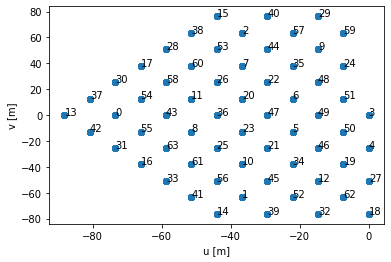

In [4]:
# uvd = UVData()
# uvd.read('/users/jburba/data/jburba/hera-validation/test-series/3/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.uvh5')

uvd_x = UVData()
x_file = '/users/jburba/data/jburba/hera-validation/test-series/3/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.X.uvh5'
uvd_x.read(x_file, read_data=False)
scatter(uvd_x.uvw_array[:, 0], uvd_x.uvw_array[:, 1])
xlabel('u [m]')
ylabel('v [m]')
for i in range(uvd_x.Nbls):
    annotate(i, (uvd_x.uvw_array[i, 0], uvd_x.uvw_array[i, 1]))

In [17]:
x_file = '/users/jburba/data/jburba/hera-validation/test-series/3/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec_realization_0_plus_egsm_and_gleam.X.uvh5'
# uvd_first_half = UVData()
# uvd_first_half.read(x_file, times=np.unique(uvd_x.time_array)[:uvd_x.Ntimes // 2])

uvd_second_half = UVData()
uvd_second_half.read(x_file, times=np.unique(uvd_x.time_array)[uvd_x.Ntimes // 2:])

Telescope RIMEz calculation is not in known_telescopes.


In [18]:
uvd_second_half.write_uvh5(x_file.replace('uvh5', 'second_half.uvh5'))

In [14]:
uvd_first_half.write_uvh5

Signature:
uvd_first_half.write_uvh5(
    filename,
    run_check=True,
    check_extra=True,
    run_check_acceptability=True,
    clobber=False,
    data_compression=None,
    flags_compression='lzf',
    nsample_compression='lzf',
    data_write_dtype=None,
)
Source:   
    def write_uvh5(self, filename, run_check=True, check_extra=True,
                   run_check_acceptability=True, clobber=False,
                   data_compression=None, flags_compression="lzf",
                   nsample_compression="lzf", data_write_dtype=None):
        """
        Write a completely in-memory UVData object to a UVH5 file.

        Parameters
        ----------
        filename : str
             The UVH5 file to write to.
        clobber : bool
            Option to overwrite the file if it already exists.
        data_compression : str
            HDF5 filter to apply when writing the data_array. Default is
            None meaning no filter or compression.
        flags_compression : str
  

In [7]:
antpairs = uvd_x.get_antpairs()
print([list(antpair) for antpair in antpairs])
print('[' + ','.join(list(map(str, antpairs))) + ']')
# '[' + ','.join([tuple() bl for ]) + ']'

[[3, 2], [9, 0], [9, 6], [9, 9], [12, 6], [13, 5], [13, 6], [13, 12], [14, 3], [16, 11], [19, 1], [19, 6], [20, 5], [22, 7], [23, 0], [23, 22], [24, 14], [24, 21], [25, 3], [25, 4], [26, 6], [27, 8], [27, 9], [27, 16], [27, 21], [27, 23], [28, 1], [28, 10], [28, 23], [29, 1], [29, 9], [29, 20], [29, 27], [30, 3], [30, 6], [30, 13], [30, 14], [30, 20], [31, 0], [31, 6], [31, 9], [31, 15], [31, 19], [32, 0], [32, 8], [32, 9], [32, 15], [33, 1], [33, 3], [34, 0], [34, 3], [34, 8], [34, 9], [34, 21], [34, 26], [35, 1], [35, 5], [35, 13], [35, 23], [35, 28], [36, 0], [36, 1], [36, 9], [36, 34]]
[(3, 2),(9, 0),(9, 6),(9, 9),(12, 6),(13, 5),(13, 6),(13, 12),(14, 3),(16, 11),(19, 1),(19, 6),(20, 5),(22, 7),(23, 0),(23, 22),(24, 14),(24, 21),(25, 3),(25, 4),(26, 6),(27, 8),(27, 9),(27, 16),(27, 21),(27, 23),(28, 1),(28, 10),(28, 23),(29, 1),(29, 9),(29, 20),(29, 27),(30, 3),(30, 6),(30, 13),(30, 14),(30, 20),(31, 0),(31, 6),(31, 9),(31, 15),(31, 19),(32, 0),(32, 8),(32, 9),(32, 15),(33, 1),(33,

In [16]:
reds, lens, angs = hera_pspec.utils.get_reds(uvd_x, pick_data_ants=False, bl_len_range=params['bl_len_range'],
                                         bl_deg_range=params['bl_deg_range'], xants=params['xants'], add_autos=True)
bls_conj = hera_pspec.utils.flatten(reds)
print(len(bls_conj), bls_conj)

543 [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (0, 1), (1, 3), (2, 4), (3, 6), (4, 7), (5, 8), (7, 10), (8, 11), (9, 12), (10, 13), (11, 14), (12, 15), (14, 17), (15, 18), (16, 19), (17, 20), (18, 21), (19, 22), (21, 24), (22, 25), (23, 26), (24, 27), (25, 28), (26, 29), (28, 31), (29, 32), (30, 33), (32, 34), (33, 35), (35, 36), (0, 2), (1, 4), (2, 5), (3, 7), (4, 8), (5, 9), (6, 10), (7, 11), (8, 12), (10, 14), (11, 15), (12, 16), (13, 17), (14, 18), (15, 19), (17, 21), (18, 22), (19, 23), (20, 24), (21, 25), (22, 26), (24, 28), (25, 29), (26, 30), (27, 31), (28, 32), (29, 33), (31, 34), (32, 35), (34, 36), (0, 4), (1, 7), (2, 8), (3, 10), (4, 11), (5, 12), (6, 13), (7, 14), (8, 15

In [18]:
35 * 34 / 2

595.0

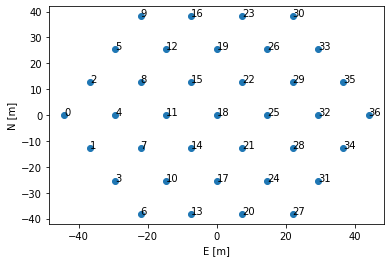

In [10]:
antpos, numbers = uvd_x.get_ENU_antpos()
scatter(antpos[:, 0], antpos[:, 1])
xlabel('E [m]')
ylabel('N [m]')
for i in numbers:
    annotate(i, (antpos[i, 0], antpos[i, 1]))

In [59]:
uvd_ref = UVData()
uvd_ref.read('/users/jburba/data/shared/HERA_IDR2.2/2458101/zen.2458101.32685.HH.OCRS.uvh5')

In [60]:
data, flags = uvd.get_data((9, 9, 'xx')), uvd.get_flags((9, 9, 'xx'))
data_x, flags_x = uvd_x.get_data((9, 9, 'xx')), uvd_x.get_flags((9, 9, 'xx'))
data_ref, flags_ref = uvd_ref.get_data((12, 12, 'xx')), uvd_ref.get_flags((12, 12, 'xx'))

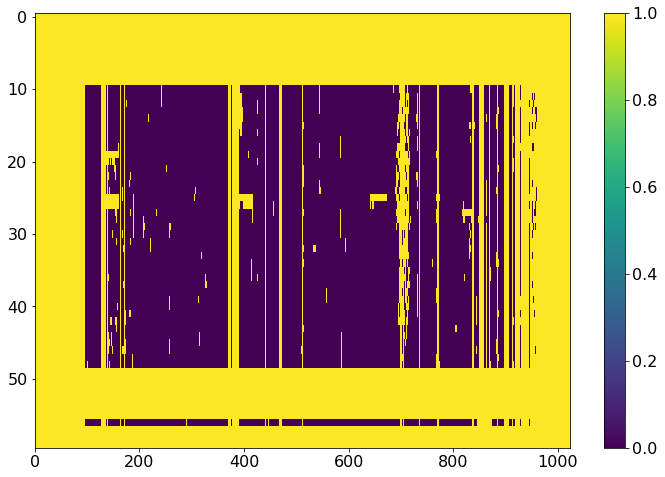

In [63]:
imshow(flags_ref.astype('int'), aspect='auto')
colorbar()

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
Invalid value encountered in median for 60 results


(nan+0j)


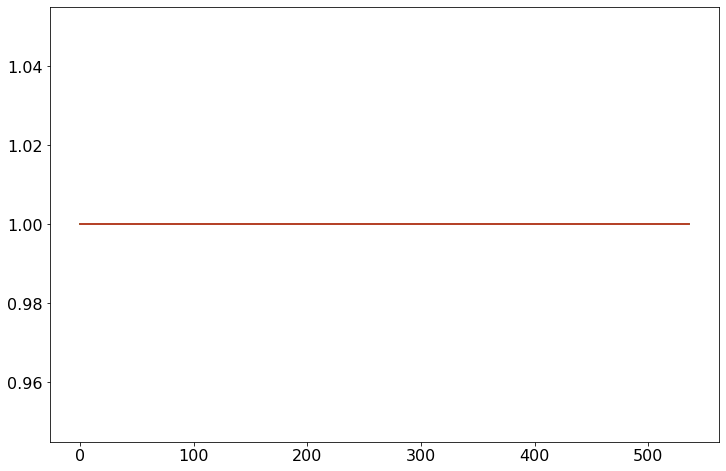

In [61]:
medians = np.median(data/(np.logical_not(flags).astype('int')), axis=(1,))
medians_x = np.median(data_x/(np.logical_not(flags_x).astype('int')), axis=(1,))
medians_ref = np.median(data_ref/(np.logical_not(flags_ref).astype('int')), axis=(1,))
print(medians_ref.max())
plot(flags_x[np.where(np.isnan(medians_x))[0]]);

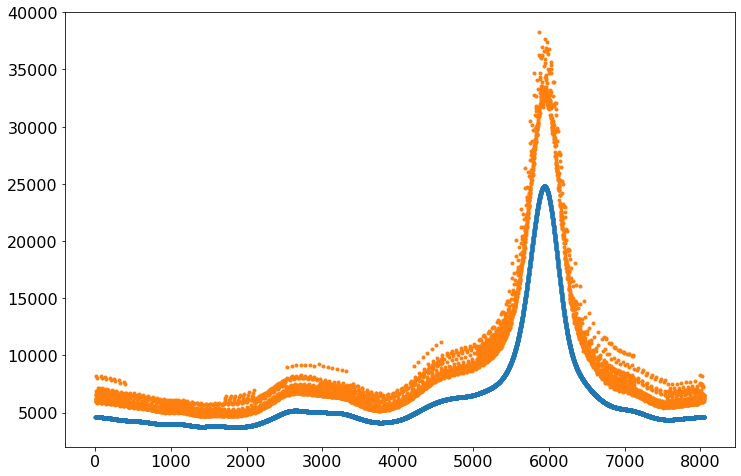

In [46]:
plot(medians.real, 'C0.')
plot(medians_x.real, 'C1.')

In [8]:
bl_groups, vec_bin_centers, lengths = uvd.get_redundancies()

In [11]:
lengths.max()

88.1999999999193

In [6]:
datafiles = sorted(glob.glob('pspec_processing/*P.uvh5'))
print(datafiles)

uvd_12552 = UVData()
uvd_12552.read('zen.2458101.12552.HH.uvh5')

uvd_12552_p = UVData()
uvd_12552_p.read(datafiles[0])

uvd_32685 = UVData()
uvd_32685.read('zen.2458101.32685.HH.uvh5')

uvd_32685_p = UVData()
uvd_32685_p.read(datafiles[1])

['pspec_processing/zen.2458101.12552.HH.P.uvh5', 'pspec_processing/zen.2458101.32685.HH.P.uvh5']


In [21]:
del(uvd_12552, uvd_12552_p, uvd_32685, uvd_32685_p)

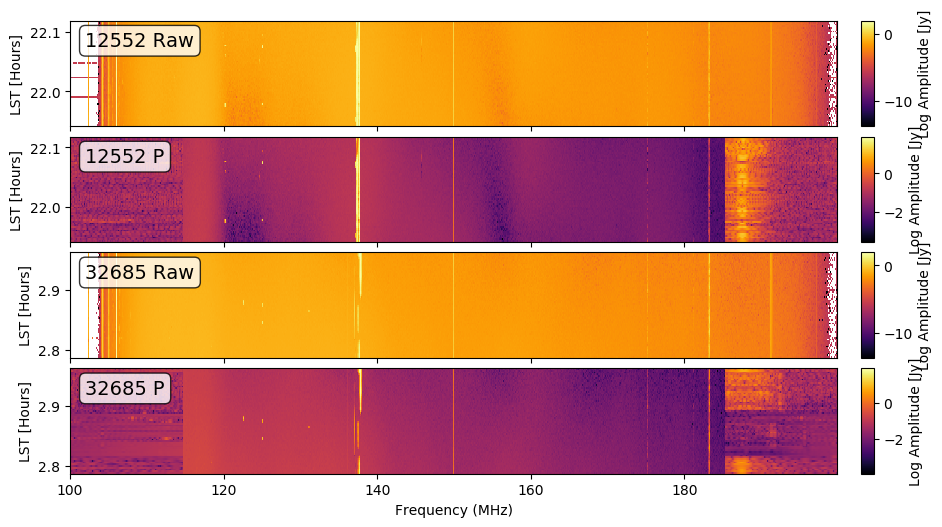

In [19]:
bl = ((12, 13, 'xx'))
extent_12552 = [uvd_12552.freq_array[0, 0] / 1.0e6, uvd_12552.freq_array[0, -1] / 1.0e6,
                np.rad2deg(uvd_12552.lst_array.min()) / 15.0, np.rad2deg(uvd_12552.lst_array.max()) / 15.0]
extent_32685 = [uvd_32685.freq_array[0, 0] / 1.0e6, uvd_32685.freq_array[0, -1] / 1.0e6,
                np.rad2deg(uvd_32685.lst_array.min()) / 15.0, np.rad2deg(uvd_32685.lst_array.max()) / 15.0]

waterfall_column([np.abs(uvd_12552.get_data(bl)), np.abs(uvd_12552_p.get_data(bl)), np.abs(uvd_32685.get_data(bl)), np.abs(uvd_32685_p.get_data(bl))],
                 [uvd_12552.get_flags(bl), uvd_12552_p.get_flags(bl), uvd_32685.get_flags(bl), uvd_32685_p.get_flags(bl)],
                 ['12552 Raw', '12552 P', '32685 Raw', '32685 P'],
                 extents = [extent_12552, extent_12552, extent_32685, extent_32685],
                 clabels = ['Amplitude [Jy]'] * 4,
                 cmaps = ['inferno'] * 4,
                 ylabel = 'LST [Hours]',
                 log = True
                )

In [74]:
# del(uvd_test)
filenames_2458101 = glob.glob('./zen.2458101.?????.HH.OCRSD.uvh5')
print(len(filenames_2458101))
for filename in filenames_2458101:
    uvd_test = UVData()
    uvd_test.read(filename, read_data=False)
    print(filename, 'units =', uvd_test.vis_units)
    del(uvd_test)

73
./zen.2458101.40887.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.47598.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.19263.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.29702.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.16280.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.44615.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.37159.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.64002.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.21500.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.59528.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.46106.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.25974.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.42378.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.53563.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.55800.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.43870.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.25228.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.51326.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.12552.HH.OCRSD.uvh5 units = UNCALIB
./zen.2458101.39396.HH.OCRSD.uvh5 units = UNCAL

___